In [2]:
import numpy as np
from matplotlib import pyplot as plt
import sys, os
sys.path.insert(1, '../quantarhei')
sys.path.insert(2, '../spectre')
import quantarhei as qr
import spectre
import spectre.full as sef
import spectre.spectroscopy.abs_spectroscopy as abss

# (1.) First version - step (s2)

In [3]:
#path = 'C:/Users/micha/Documents/Studium/MScThesis/data-meta/E-scanopt-ether02-1mode/results_E-ether02-1mode-11010_scanopt_01_2023-07-01_14-14-11/'
path = 'C:/Users/micha/Documents/Studium/MScThesis/data-meta/E-scanopt-ether02-1mode-free/results_E-ether02-1mode-free-P-11010_scanopt_01_2023-07-06_15-18-40'

In [4]:
files = [file for file in os.listdir(path) if file.endswith('.json') and file.startswith('opt')]
sfiles = sorted(files, key=lambda s: float(s.split('.')[0].split('_')[2]))

C:\Users\micha\AppData\Local\Temp\ipykernel_28976\4220604495.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  clm = cm.get_cmap('viridis', len(files))
C:\Users\micha\AppData\Local\Temp\ipykernel_28976\4220604495.py:32: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='horizontal')


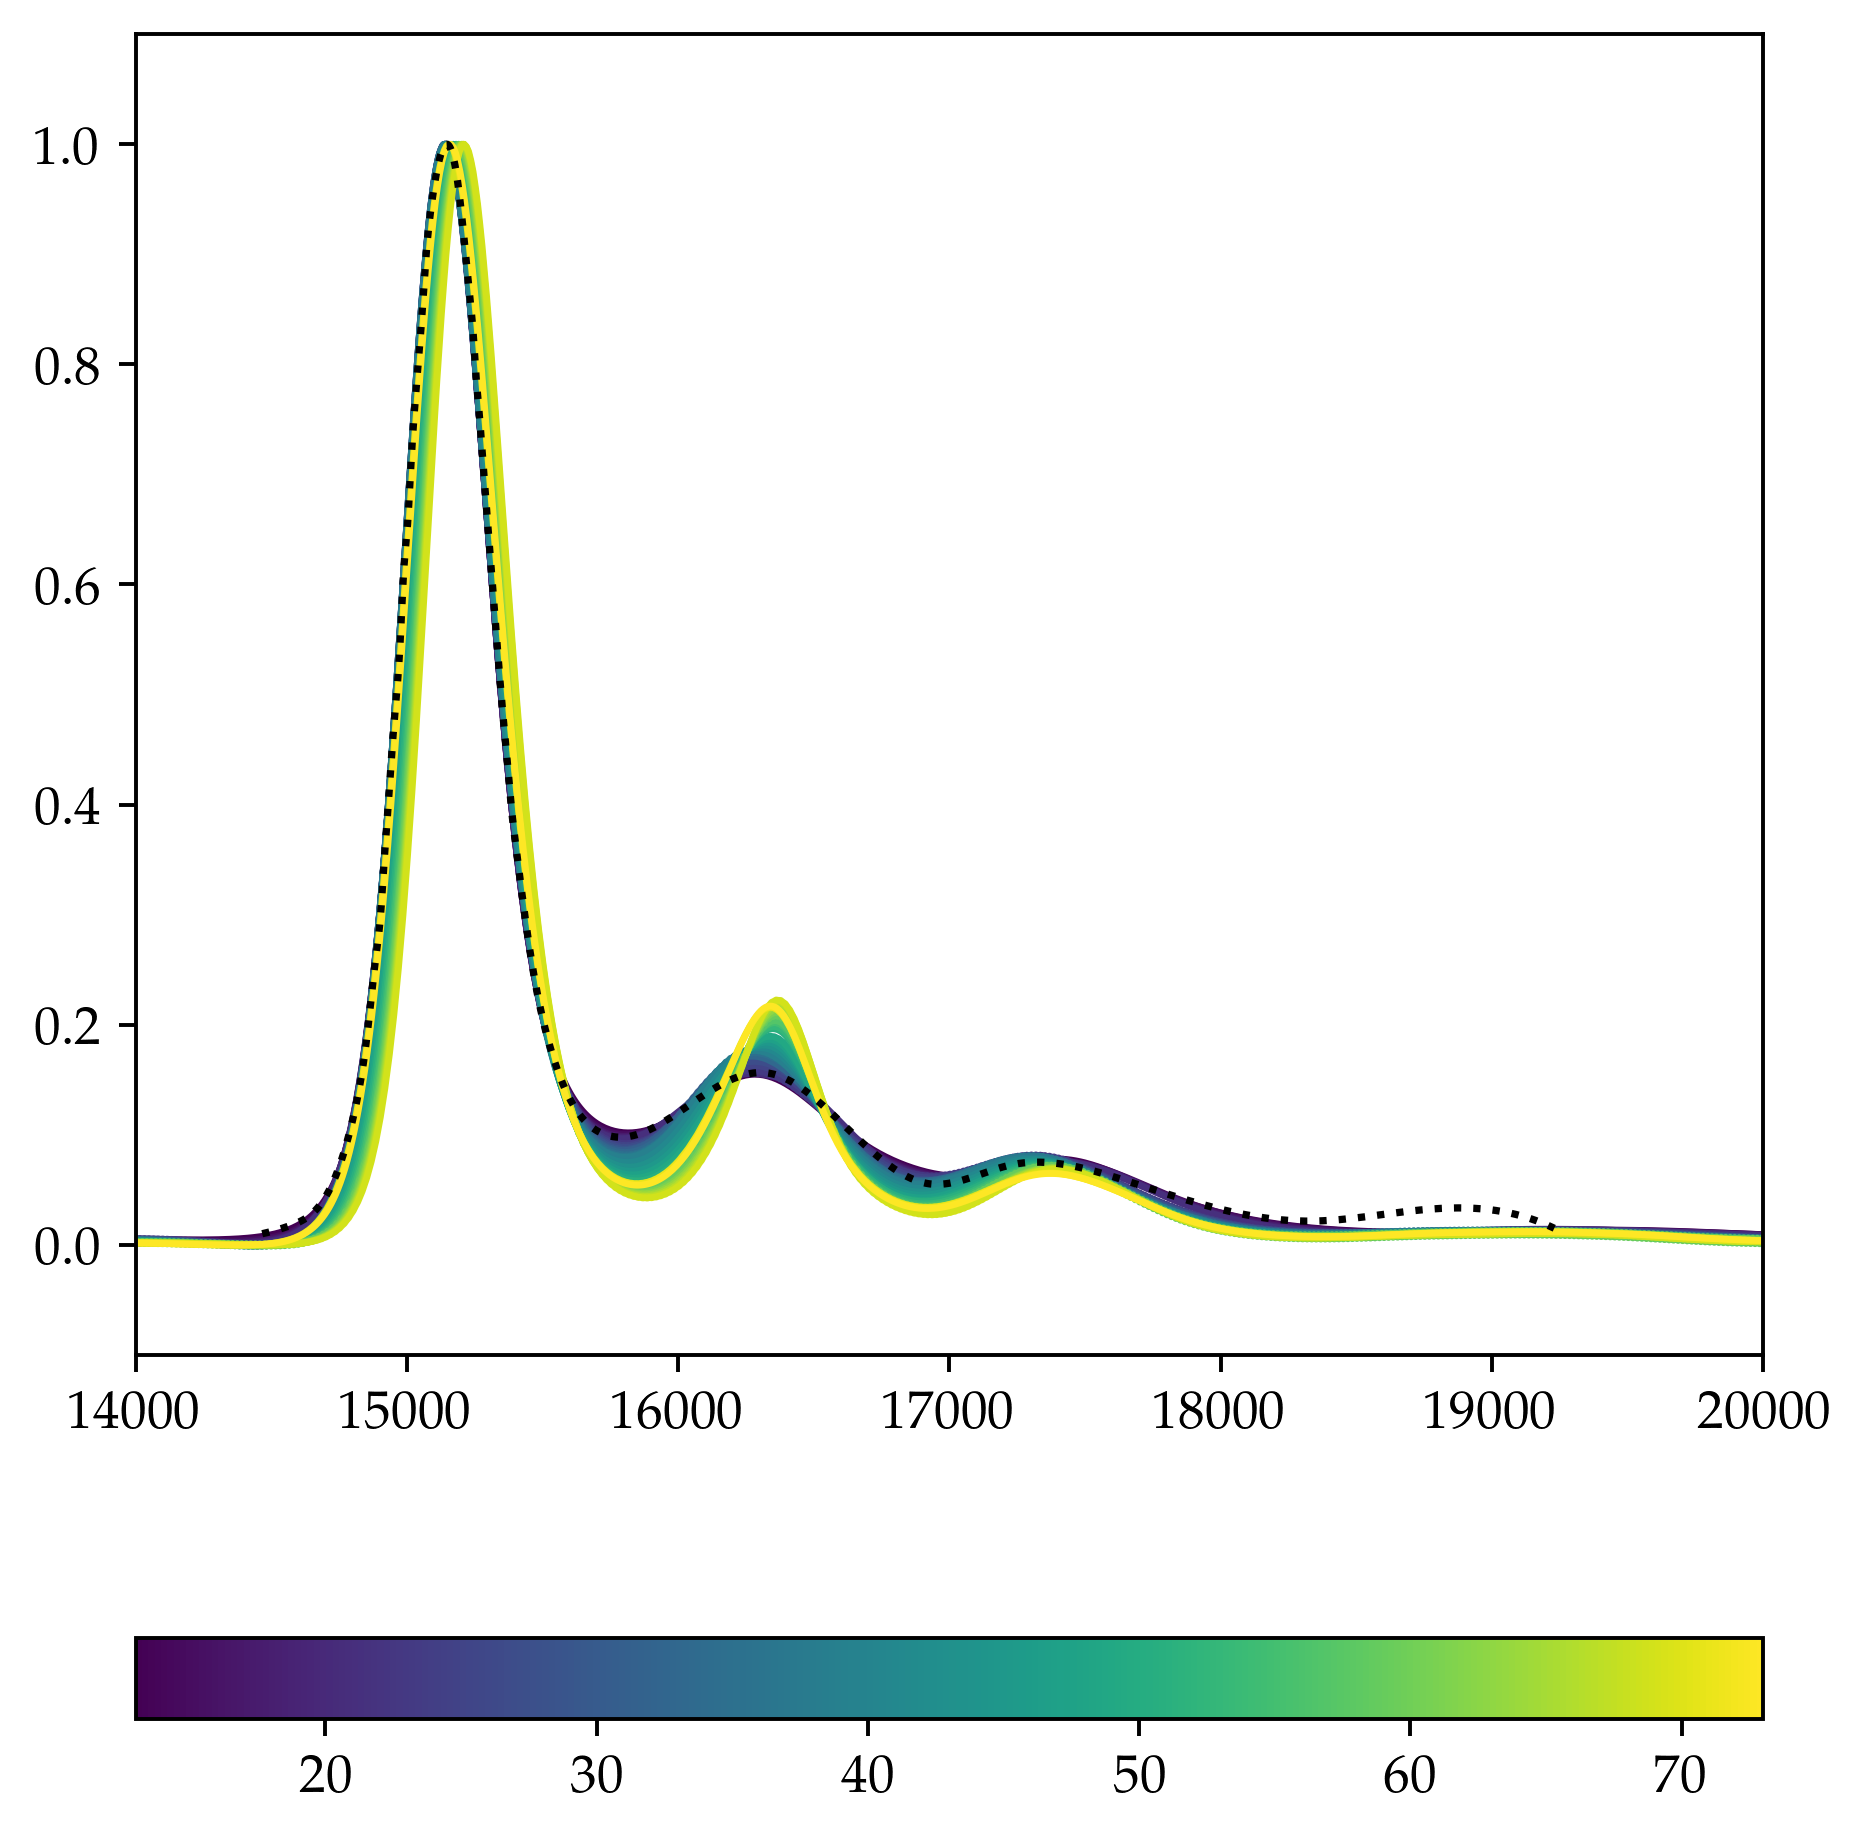

In [5]:
from matplotlib import cm
clm = cm.get_cmap('viridis', len(files))

fig, ax = plt.subplots(figsize=(6,7), dpi= 350)
labels = list()

for i, f in enumerate(sfiles[:]):
    filepath = os.path.join(path, f)
    optpars = spectre.utils.loadjson(filepath)
    datapath = filepath.replace('.json', '.npy')
    
    if os.path.isfile(datapath):
        data = np.load(datapath)
    else:
        syst, ta = spectre.full.init_system(optpars)
        spec = abss.calculate_abs_spectrum(syst, ta, optpars)
        spec.normalize()
        
        with qr.energy_units('1/cm'):
            data = np.vstack([spec.axis.data, spec.data])
            np.save(datapath, data)

    lab = f.split('.')[0].split('_')[2]
    plt.plot(data[0], data[1], label=lab, linewidth=1.4, color=clm(i))
    labels.append(lab)

plt.xlim(14000, 20000)
plt.ylim(-0.1, 1.1)
#plt.legend(frameon=False)

sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(labels[0], labels[-1]))
cbar = plt.colorbar(sm, orientation='horizontal')
#cbar.set_ticklabels(labs)

abss.plot_ref(2, plot_to=ax, color='k', linestyle = 'dotted')

C:\Users\micha\AppData\Local\Temp\ipykernel_28976\1714277891.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  clm = cm.get_cmap('viridis', len(files))
C:\Users\micha\AppData\Local\Temp\ipykernel_28976\1714277891.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot(gs[3])


0.313830306708


Text(0, 0.5, 'residuum')

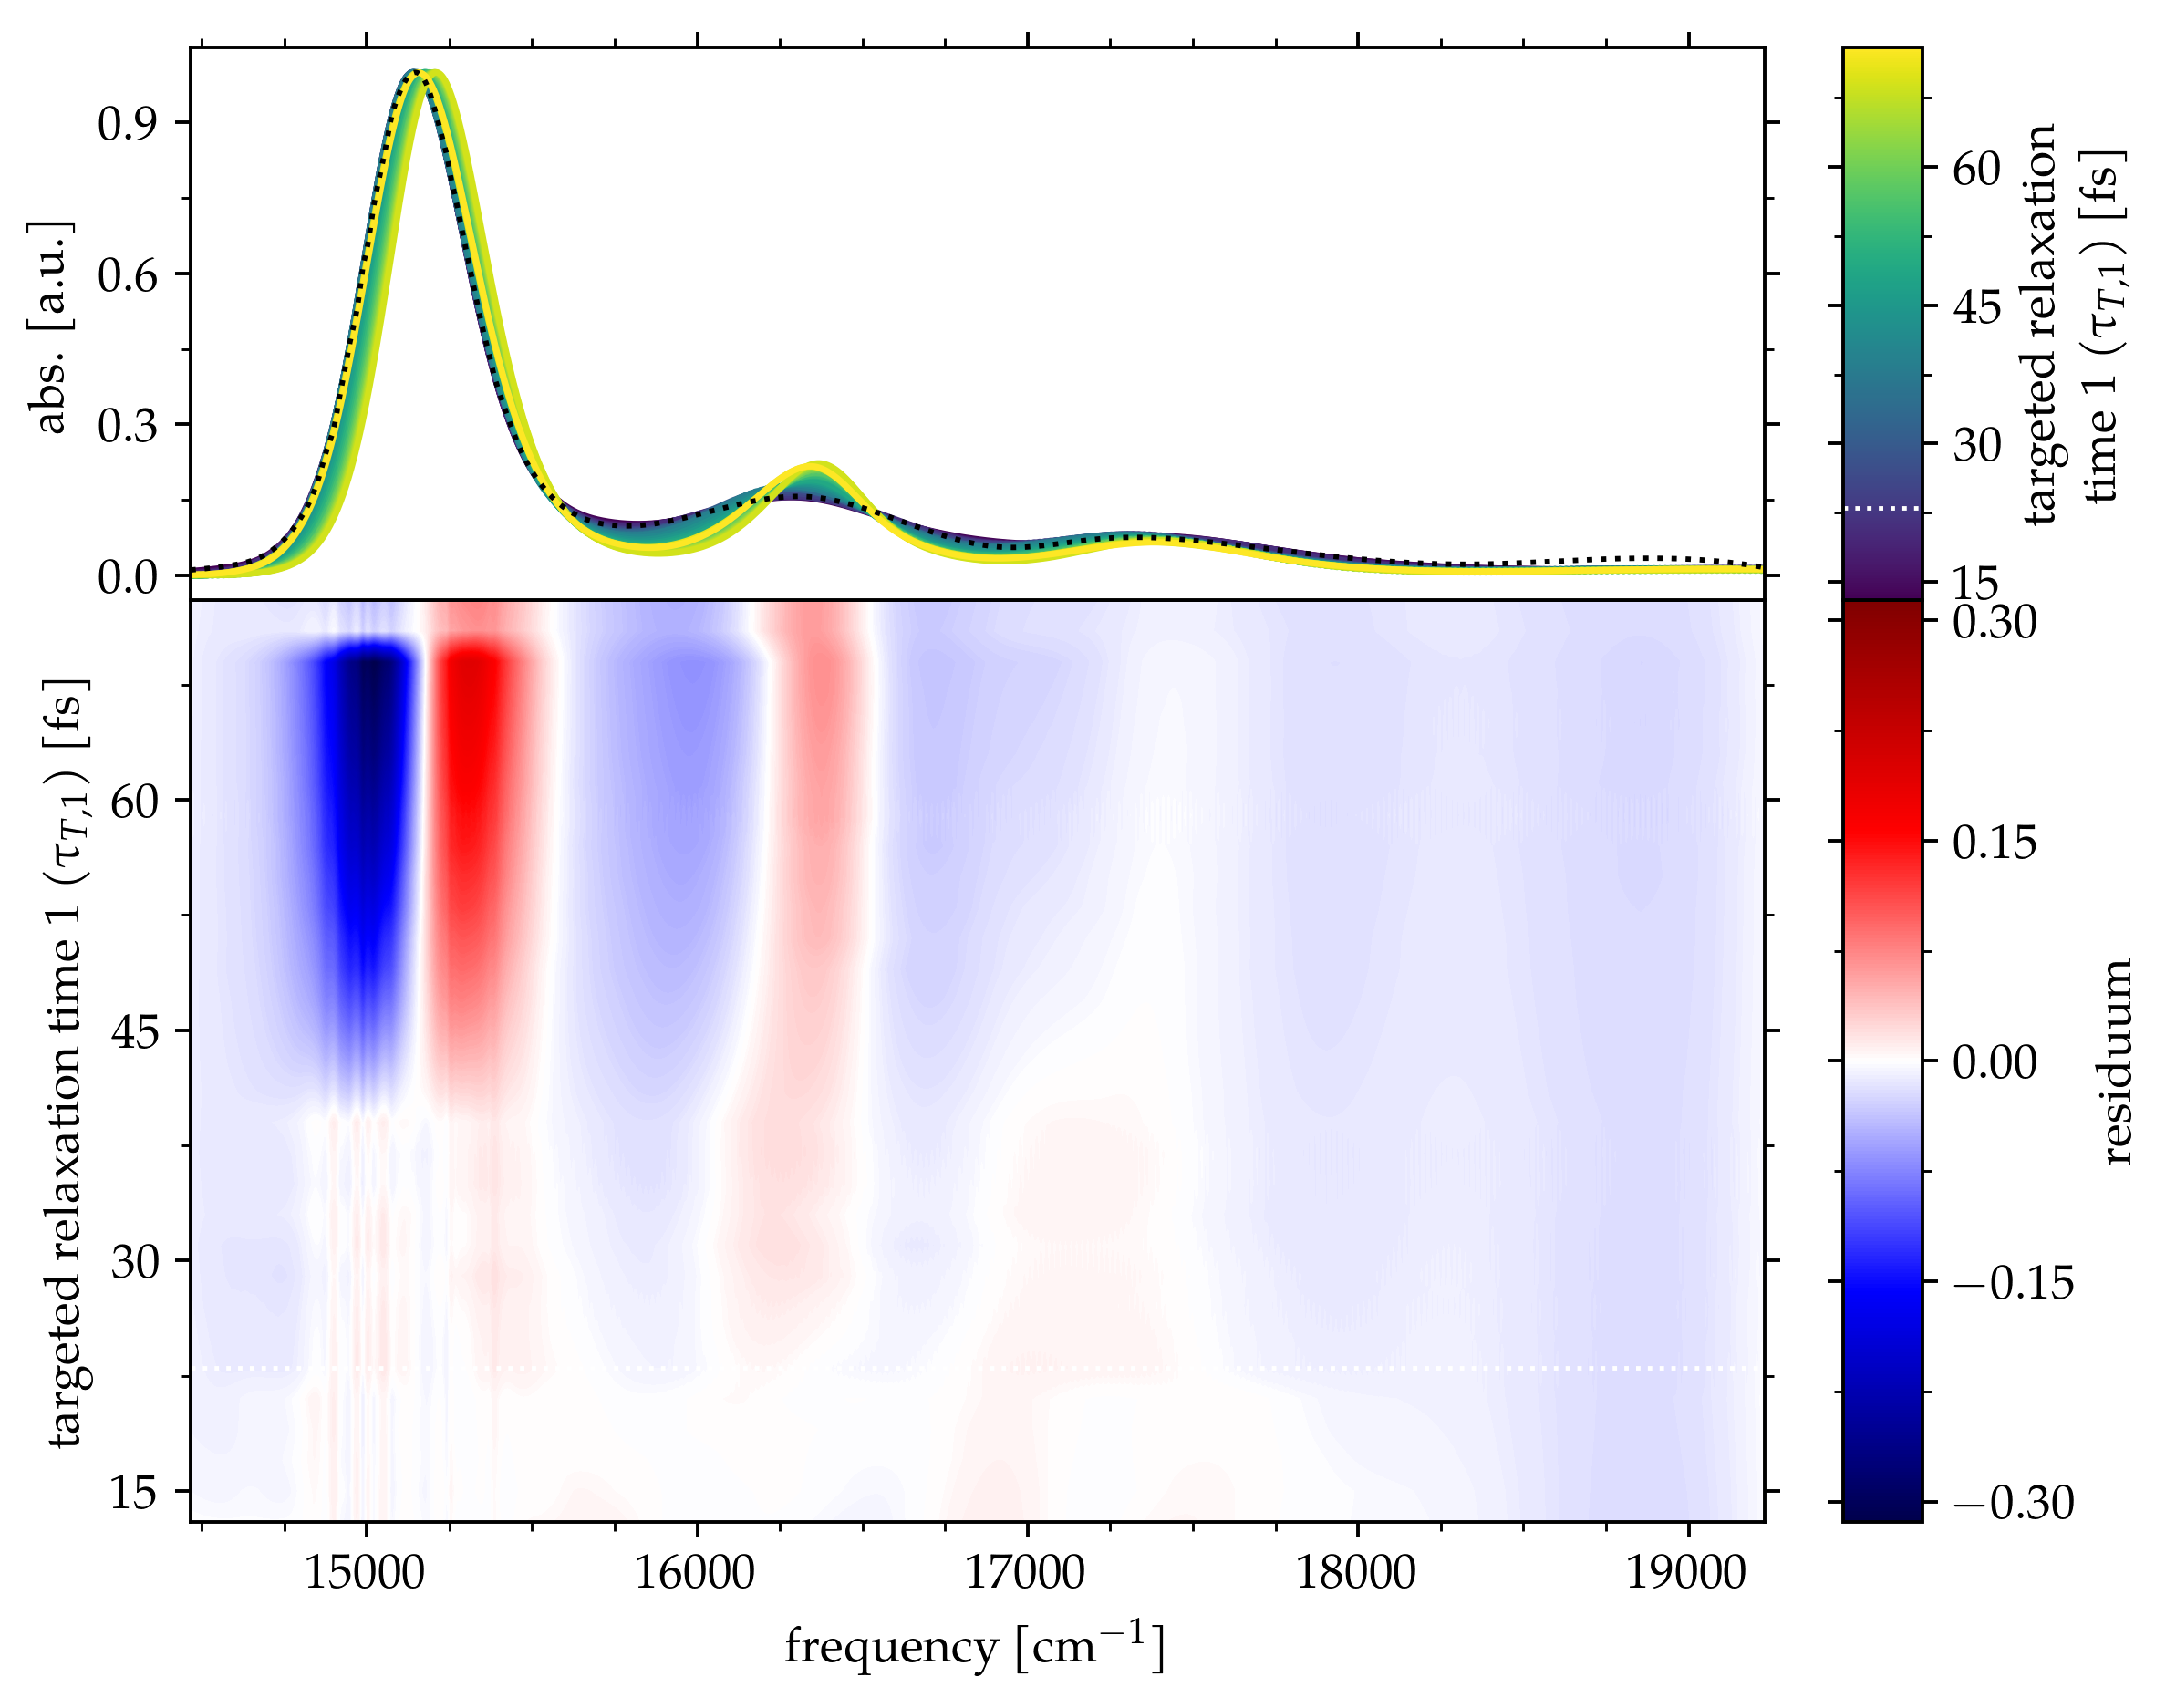

In [10]:
from matplotlib import cm
from scipy.interpolate import UnivariateSpline
from tqdm import tqdm
from matplotlib import gridspec

spline_s=0.0002
spline_k=3

clm = cm.get_cmap('viridis', len(files))

refdata = abss.plot_ref(2, return_data='data', plot=False)
refx, refy = refdata

fig, ax = plt.subplots(num=None, figsize=(7,6), dpi=350, facecolor='w', edgecolor='k')
gs = gridspec.GridSpec(nrows=2, ncols=3, width_ratios=(1, 0.05, 0.05), height_ratios=(0.6, 1), figure=fig) 
#ax3 = plt.subplot(gs[3])
ax0 = plt.subplot(gs[3])
ax1 = plt.subplot(gs[0], sharex = ax0)
ax4 = plt.subplot(gs[5])
ax2 = plt.subplot(gs[2])
plt.subplots_adjust(hspace=0, wspace=0)

####################
#   ax1   #  # ax2 #
####################
#   ax0   #  # ax4 #
####################

all_data_filename = 'all_data.npy'
all_data_path = os.path.join(path, all_data_filename)

if os.path.isfile(all_data_path) and True:
    x, y, zdata = np.load(all_data_path)

    for i, z in enumerate(zdata):
        ax1.plot(x[i], z, linewidth=1.4, color=clm(i))
    
    zax = zdata - refy

else:
    labels = list()
    zax = None
    zdata = None
    i = 0

    for f in tqdm(sfiles[:]):
        i += 1
        filepath = os.path.join(path, f)
        optpars = spectre.utils.loadjson(filepath)
        datapath = filepath.replace('.json', '.npy')
        
        if os.path.isfile(datapath):
            data = np.load(datapath)
        else:
            syst, ta = spectre.full.init_system(optpars)
            spec = abss.calculate_abs_spectrum(syst, ta, optpars)
            spec.normalize()
            
            with qr.energy_units('1/cm'):
                data = np.vstack([spec.axis.data, spec.data])
                np.save(datapath, data)
    
        lab = f.split('.')[0].split('_')[2]
        spline = UnivariateSpline(*data, k=spline_k, s=spline_s)
        ydat = spline(refx) - refy
        
        if zax is None:
            zax = ydat
            zdata = spline(refx)
        else:
            zax = np.vstack([zax, ydat])
            zdata = np.vstack([zdata, spline(refx)])
        
        ax1.plot(data[0], data[1], label=lab, linewidth=1.4, color=clm(i))
        labels.append(float(lab))

    yax = np.array(labels)
    xax = refx
    x, y = np.meshgrid(xax, yax)
    np.save(all_data_path, np.array([x, y, zdata]))

maximum = np.abs(zax).max()
print(maximum)

cf = ax0.contourf(x, y, zax, 500, cmap="seismic", vmax=maximum, vmin=-maximum)

#CS = ax0.contour(x, y, zax, 5)
#ax0.clabel(CS, inline=True, fontsize=10)

sm = plt.cm.ScalarMappable(cmap='seismic', norm=plt.Normalize(-maximum, maximum))
cbar = plt.colorbar(sm, cax=ax4, orientation='vertical')

sm2 = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(y[0,0], y[-1,0]))
cbar2 = plt.colorbar(sm2, cax=ax2, orientation='vertical')

ax0.plot([x[0,0], x[0,-1]], [23,23], linewidth=1, linestyle='dotted', c='w')
ax2.plot([0, 1], [23,23], linewidth=1, linestyle='dotted', c='w')

abss.plot_ref(2, plot_to=ax1, linestyle='dotted', c='k', linewidth=1.2)

from matplotlib.ticker import MultipleLocator, AutoMinorLocator, MaxNLocator

for g in [ax0, ax1, ax2, ax4]:
    pars = dict(labelbottom=False, labeltop=False, labelleft=True, labelright=False,
                bottom=True,           top=True,      left=True,      right=True,)
    g.tick_params(which='both', **pars)
    
    #g.xaxis.set_major_locator(MultipleLocator(20))
    #g.xaxis.set_major_formatter('{x:.0f}')
    #g.xaxis.set_minor_locator(MultipleLocator(10))
    g.yaxis.set_major_locator(MaxNLocator(nbins=4))
    g.yaxis.set_minor_locator(AutoMinorLocator(2))
    g.xaxis.set_minor_locator(AutoMinorLocator(4))
    #g.ticklabel_format(style='sci', axis='y', scilimits=(-1,3), useOffset=True)

    #g.get_yaxis().set_offset_position("left")
    #g.get_yaxis().OFFSETTEXTPAD = 7
    #g.get_yaxis().get_offset_text().set_position((-0.097,0))

ax4.yaxis.set_major_locator(MaxNLocator(nbins=5))

ax0.tick_params(which='both', labelbottom=True, labelleft=True)
ax1.tick_params(which='both', bottom=False)
ax2.tick_params(which='both', labelleft=False, labelright=True)
ax4.tick_params(which='both', labelleft=False, labelright=True)

ax0.set_xlim(x[0,0], x[0,-1])
ax1.set_ylim(-0.05, 1.05)

ax0.set_xlabel(r'frequency [cm$^{-1}$]')
ax0.set_ylabel(r'targeted relaxation time 1 ($\uptau_{T,1}$) [fs]')
ax1.set_ylabel(r'abs. [a.u.]')
ax2.set_ylabel(r'\parbox{40mm}{\centering targeted relaxation time 1 ($\uptau_{T,1}$) [fs]}')
ax4.set_ylabel(r'residuum')

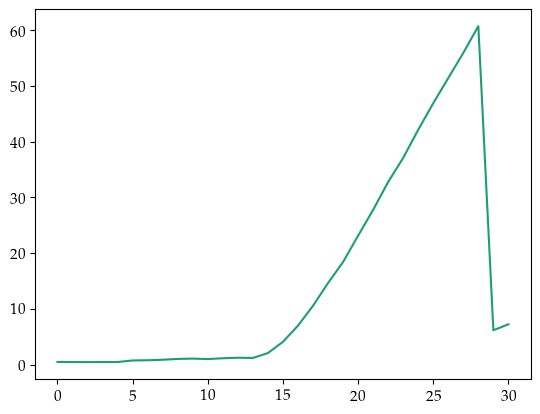

In [7]:
plt.plot((zax**2).sum(axis=1))

In [8]:
def draw_line(plot_to, xaxis, *vals, **pars):
    for val in vals:
        plot_to.plot([xaxis[0]-10, xaxis[-1]+10], [val, val], **pars)

C:\Users\micha\AppData\Local\Temp\ipykernel_28976\1409679701.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  clm = cm.get_cmap('viridis', len(files))


Text(0.5, 0, 'targeted relaxation time 1 ($\\uptau_{T,1}$) [fs]')

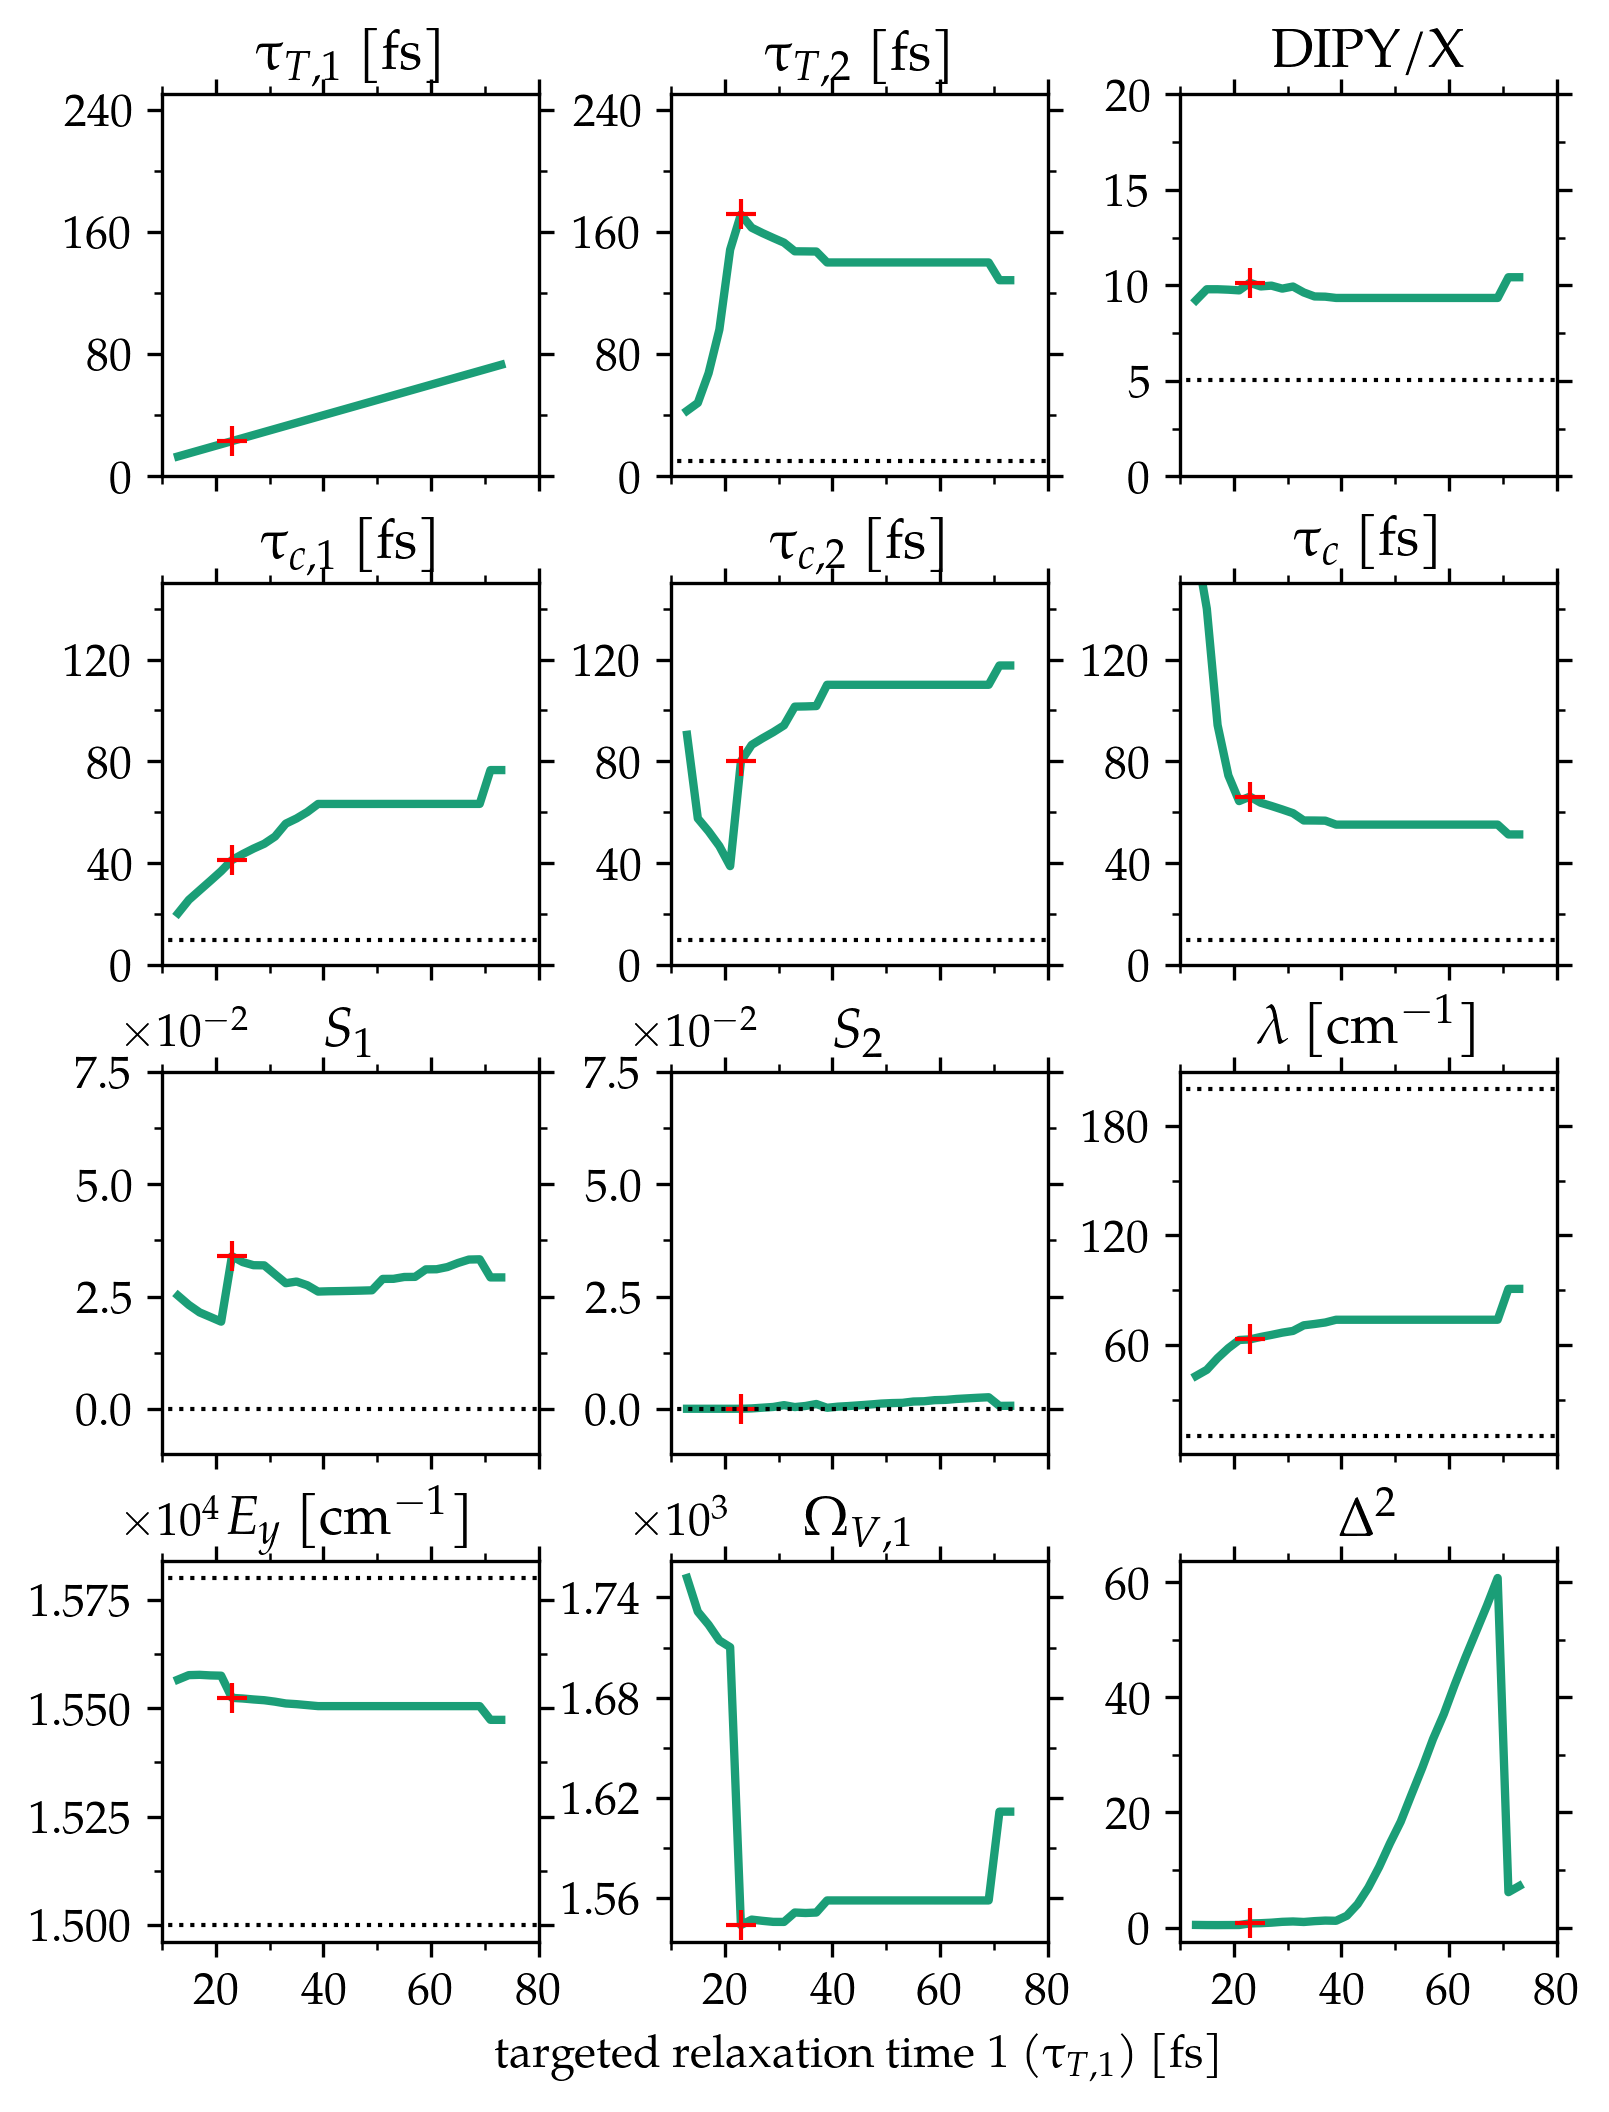

In [20]:
from matplotlib import cm
from spectre.matplotlib_latex import plt_latex, format_ticks

plt_latex()
clm = cm.get_cmap('viridis', len(files))

fig, grid = plt.subplots(4, 3, figsize=(6,8), dpi=300, sharex=True, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=0.28, wspace=0.35)

labels = list()

tt11 = list()
tt12 = list()
dipyx = list()
ct11 = list()
ct12 = list()
ct = list()
lamb = list()
hr11 = list()
hr12 = list()
e1 = list()
de = list()
om1 = list()
alpha = list()

for i, f in enumerate(sfiles[:]):
    filepath = os.path.join(path, f)
    optpars = spectre.utils.loadjson(filepath)
    datapath = filepath.replace('.json', '.npy')
    
    if os.path.isfile(datapath):
        data = np.load(datapath)
    else:
        syst, ta = spectre.full.init_system(optpars)
        spec = abss.calculate_abs_spectrum(syst, ta, optpars)
        spec.normalize()
        
        with qr.energy_units('1/cm'):
            data = np.vstack([spec.axis.data, spec.data])
            np.save(datapath, data)

    lab = f.split('.')[0].split('_')[2]
    labels.append(float(lab))

    tt11.append(optpars['scaled_OB_CF_vib_11']['target_time'])
    tt12.append(optpars['scaled_OB_CF_vib_12']['target_time'])
    dipyx.append(4.5**2 / optpars['dipx'][0]**2)
    ct11.append(optpars['scaled_OB_CF_vib_11']['cortime'])
    ct12.append(optpars['scaled_OB_CF_vib_12']['cortime'])
    ct.append(optpars['spectral_density_el']['cortime'])
    lamb.append(optpars['spectral_density_el']['reorg'])
    hr11.append(optpars['hr1'][0])
    hr12.append(optpars['hr1'][1])
    e1.append(optpars['energies'][1])
    de.append(optpars['energies'][2] - optpars['energies'][1])
    om1.append(optpars['omega'][0])
    alpha.append(optpars['dia_alpha1'])

ii = [i for i,x in enumerate(labels) if x == 23][0]

### Line & marker parameters
pars = dict(linewidth=2, )
mpars = dict(marker='+', c='r', markersize=7)
lpars = dict(linewidth=1, linestyle='dotted', c='k')


## TT11
grid[0,0].plot(labels, tt11, **pars)
grid[0,0].plot(labels[ii], tt11[ii], **mpars)
grid[0,0].set_title(r'$\uptau_{T,1}$ [fs]')

## TT12
grid[0,1].plot(labels, tt12, **pars)
grid[0,1].plot(labels[ii], tt12[ii], **mpars)
grid[0,1].set_title(r'$\uptau_{T,2}$ [fs]')
draw_line(grid[0,1], labels, 10, 300, **lpars)
          
## DIP Y/X
grid[0,2].plot(labels, dipyx, **pars)
grid[0,2].plot(labels[ii], dipyx[ii], **mpars)
grid[0,2].set_title('DIPY/X')
draw_line(grid[0,2], labels, 4.5**2 / 0.2**2, 4.5**2 / 2**2, **lpars)

## CT11
grid[1,0].plot(labels, ct11, **pars)
grid[1,0].plot(labels[ii], ct11[ii], **mpars)
grid[1,0].set_title(r'$\uptau_{c,1}$ [fs]')
draw_line(grid[1,0], labels, 10, 200, **lpars)

## CT12
grid[1,1].plot(labels, ct12, **pars)
grid[1,1].plot(labels[ii], ct12[ii], **mpars)
grid[1,1].set_title(r'$\uptau_{c,2}$ [fs]')
draw_line(grid[1,1], labels, 10, 200, **lpars)

## CT
grid[1,2].plot(labels, ct, **pars)
grid[1,2].plot(labels[ii], ct[ii], **mpars)
grid[1,2].set_title(r'$\uptau_{c}$ [fs]')
draw_line(grid[1,2], labels, 10, 200, **lpars)

## HR11
grid[2,0].plot(labels, hr11, **pars)
grid[2,0].plot(labels[ii], hr11[ii], **mpars)
grid[2,0].set_title(r'$S_1$')
draw_line(grid[2,0], labels, 0.00001, 0.4, **lpars)

## HR12
grid[2,1].plot(labels, hr12, **pars)
grid[2,1].plot(labels[ii], hr12[ii], **mpars)
grid[2,1].set_title(r'$S_2$')
draw_line(grid[2,1], labels, 0.00001, 0.4, **lpars)

## lambda
grid[2,2].plot(labels, lamb, **pars)
grid[2,2].plot(labels[ii], lamb[ii], **mpars)
grid[2,2].set_title(r'$\lambda$ [cm$^{-1}$]')
draw_line(grid[2,2], labels, 10, 200, **lpars)

## e1
grid[3,0].plot(labels, e1, **pars)
grid[3,0].plot(labels[ii], e1[ii], **mpars)
grid[3,0].set_title(r'$E_y$ [cm$^{-1}$]')
draw_line(grid[3,0], labels, 15000, 15800, **lpars)

## omega
grid[3,1].plot(labels, om1, **pars)
grid[3,1].plot(labels[ii], om1[ii], **mpars)
grid[3,1].set_title(r'$\Omega_{V,1}$')
#draw_line(grid[3,1], labels, 0.00001, 0.4, **lpars)

# ## alpha
# grid[3,2].plot(labels, alpha, **pars)
# grid[3,2].plot(labels[ii], alpha[ii], **mpars)
# grid[3,2].set_title(r'$\alpha$')
# #draw_line(grid[3,2], labels, 0.00001, 0.4, **lpars)

## alpha
delta = (zax**2).sum(axis=1)
grid[3,2].plot(labels, delta, **pars)
grid[3,2].plot(labels[ii], delta[ii], **mpars)
grid[3,2].set_title(r'$\Delta^2$')
#draw_line(grid[3,2], labels, 0.00001, 0.4, **lpars)
    


grid[0,0].set_ylim(0,250)
grid[0,1].sharey(grid[0,0])
# grid[0,1].set_ylim(0,250)

grid[1,0].set_ylim(0,150)
grid[1,1].sharey(grid[1,0])
grid[1,2].sharey(grid[1,0])
# grid[1,1].set_ylim(0,100)
# grid[1,2].set_ylim(0,100)

grid[2,0].set_ylim(-0.01, 0.075)
grid[2,1].sharey(grid[2,0])
# grid[2,1].set_ylim(-0.01, 0.075)

grid[0,0].set_xlim(10, 80)

grid[0,2].set_ylim(0,20)

#plt.xlim(14000, 20000)
#plt.ylim(-0.1, 1.1)
#plt.legend(frameon=False)

#sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(labels[0], labels[-1]))
#cbar = plt.colorbar(sm, orientation='horizontal')
#cbar.set_ticklabels(labs)

### TICKS
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, MaxNLocator

for g in grid[:].flatten():
    pars = dict(labelbottom=False, labeltop=False, labelleft=True, labelright=False,
                bottom=True,           top=True,      left=True,      right=True,)
    #minor_pars = dict(bottom=True,           top=True,      left=True,      right=True)
    g.tick_params(which='both', **pars)
    #g.minor_tick_params(**minor_pars)
    
    g.xaxis.set_major_locator(MultipleLocator(20))
    g.xaxis.set_major_formatter('{x:.0f}')
    g.xaxis.set_minor_locator(MultipleLocator(10))
    g.yaxis.set_major_locator(MaxNLocator(nbins=4))
    g.yaxis.set_minor_locator(AutoMinorLocator(2))
    g.ticklabel_format(style='sci', axis='y', scilimits=(-1,3), useOffset=True)

    g.get_yaxis().set_offset_position("left")
    g.get_yaxis().OFFSETTEXTPAD = 7
    #g.get_yaxis().get_offset_text().set_position((-0.032,0))
    g.get_yaxis().get_offset_text().set_position((-0.097,0))

for g in grid[-1].flatten():
    pars = dict(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
    g.tick_params(which='both', **pars)

# plt.locator_params(axis='x', nbins=4)
# plt.locator_params(axis='y', nbins=4)
#fig.tight_layout()

grid[3,1].set_xlabel(r'targeted relaxation time 1 ($\uptau_{T,1}$) [fs]')

# (2.) - Finer step - (s1)

In [10]:
path = 'C:/Users/micha/Documents/Studium/MScThesis/data-meta/E-scanopt-ether02-1mode-free/results_E-ether02-1mode-free-s1-P-11010_scanopt_01_2023-07-10_10-26-52'

In [11]:
files = [file for file in os.listdir(path) if file.endswith('.json') and file.startswith('opt')]
sfiles = sorted(files, key=lambda s: float(s.split('.')[0].split('_')[2]))

C:\Users\micha\AppData\Local\Temp\ipykernel_46936\4220604495.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  clm = cm.get_cmap('viridis', len(files))


Reorg: 1189.26733282
Reorg: 755.456871063
System init: 6.28s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.7s finished


Tensor calculation: 2.71s
Spectrum calculation (CPU): 7.94s
Reorg: 1057.70592735
Reorg: 355.29507087
System init: 5.79s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.9s finished


Tensor calculation: 2.59s
Spectrum calculation (CPU): 8.18s
Reorg: 953.477889198
Reorg: 162.738174121
System init: 5.92s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.5s finished


Tensor calculation: 2.74s
Spectrum calculation (CPU): 7.69s
Reorg: 1279.31416304
Reorg: 2328.76913792
System init: 5.96s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.5s finished


Tensor calculation: 2.54s
Spectrum calculation (CPU): 7.71s
Reorg: 1297.22563401
Reorg: 2460.24458213
System init: 5.81s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    8.0s finished


Tensor calculation: 2.69s
Spectrum calculation (CPU): 8.26s
Reorg: 1462.90294108
Reorg: 2291.27853404
System init: 5.76s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.4s finished


Tensor calculation: 2.47s
Spectrum calculation (CPU): 7.63s
Reorg: 1419.9653759
Reorg: 2362.1616191
System init: 5.93s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.7s finished


Tensor calculation: 2.65s
Spectrum calculation (CPU): 7.91s
Reorg: 1443.23898988
Reorg: 2059.35021444
System init: 5.53s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.6s finished


Tensor calculation: 2.64s
Spectrum calculation (CPU): 7.82s
Reorg: 1460.4407245
Reorg: 723.45003859
System init: 5.77s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.2s finished


Tensor calculation: 2.49s
Spectrum calculation (CPU): 7.38s
Reorg: 1442.69966444
Reorg: 487.333351367
System init: 5.98s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    8.0s finished


Tensor calculation: 2.62s
Spectrum calculation (CPU): 8.17s
Reorg: 1699.22949998
Reorg: 141.121363278
System init: 5.72s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.3s finished


Tensor calculation: 2.91s
Spectrum calculation (CPU): 7.47s
Reorg: 1668.54878714
Reorg: 142.024117932
System init: 5.99s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.7s finished


Tensor calculation: 2.50s
Spectrum calculation (CPU): 7.89s
Reorg: 1544.17163395
Reorg: 171.840076904
System init: 5.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    8.1s finished


Tensor calculation: 2.54s
Spectrum calculation (CPU): 8.26s
Reorg: 1557.78127366
Reorg: 175.126715505
System init: 5.58s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.5s finished


Tensor calculation: 2.74s
Spectrum calculation (CPU): 7.70s
Reorg: 1467.96364553
Reorg: 270.268015144
System init: 6.03s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.7s finished


Tensor calculation: 2.76s
Spectrum calculation (CPU): 7.95s
Reorg: 1395.4780249
Reorg: 361.520046843
System init: 5.61s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.8s finished


Tensor calculation: 2.51s
Spectrum calculation (CPU): 7.97s
Reorg: 1398.3509399
Reorg: 425.452715797
System init: 5.62s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.5s finished


Tensor calculation: 2.86s
Spectrum calculation (CPU): 7.71s
Reorg: 1449.15637284
Reorg: 523.191037305
System init: 6.14s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.5s finished


Tensor calculation: 2.61s
Spectrum calculation (CPU): 7.76s
Reorg: 1459.98328909
Reorg: 543.795729913
System init: 5.77s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.5s finished


Tensor calculation: 2.78s
Spectrum calculation (CPU): 7.75s
Reorg: 1432.61763325
Reorg: 578.742748235
System init: 5.63s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.1s finished


Tensor calculation: 2.85s
Spectrum calculation (CPU): 7.29s
Reorg: 1437.92046876
Reorg: 595.815512039
System init: 5.40s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.25s
Spectrum calculation (CPU): 7.05s
Reorg: 1440.71871811
Reorg: 596.110536682
System init: 5.00s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.1s finished


Tensor calculation: 2.30s
Spectrum calculation (CPU): 7.33s
Reorg: 1423.73222928
Reorg: 619.890344277
System init: 4.99s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.1s finished


Tensor calculation: 2.27s
Spectrum calculation (CPU): 7.35s
Reorg: 1426.70778927
Reorg: 638.411437581
System init: 4.92s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.3s finished


Tensor calculation: 2.30s
Spectrum calculation (CPU): 7.54s
Reorg: 1437.77881984
Reorg: 607.092076761
System init: 5.01s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.30s
Spectrum calculation (CPU): 7.02s
Reorg: 1394.20976469
Reorg: 607.092076761
System init: 5.03s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.26s
Spectrum calculation (CPU): 7.15s
Reorg: 1353.20727582
Reorg: 607.09207993
System init: 5.00s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.1s finished


Tensor calculation: 2.41s
Spectrum calculation (CPU): 7.34s
Reorg: 1314.5455007
Reorg: 607.092080382
System init: 5.03s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.3s finished


Tensor calculation: 2.25s
Spectrum calculation (CPU): 7.47s
Reorg: 1278.03191108
Reorg: 607.092083112
System init: 4.95s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.7s finished


Tensor calculation: 2.32s
Spectrum calculation (CPU): 6.89s
Reorg: 1243.49344769
Reorg: 607.092085587
System init: 5.01s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.4s finished


Tensor calculation: 2.27s
Spectrum calculation (CPU): 7.65s
Reorg: 1210.77250303
Reorg: 607.09208613
System init: 5.58s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    8.0s finished


Tensor calculation: 2.68s
Spectrum calculation (CPU): 8.25s
Reorg: 1179.72949534
Reorg: 607.092090287
System init: 5.66s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.8s finished


Tensor calculation: 2.74s
Spectrum calculation (CPU): 7.97s
Reorg: 1150.23715245
Reorg: 607.092090848
System init: 5.84s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.3s finished


Tensor calculation: 2.71s
Spectrum calculation (CPU): 7.57s
Reorg: 1122.20526978
Reorg: 607.091836267
System init: 6.09s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.7s finished


Tensor calculation: 2.59s
Spectrum calculation (CPU): 7.94s
Reorg: 1095.4870226
Reorg: 607.091838522
System init: 5.59s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.9s finished


Tensor calculation: 2.70s
Spectrum calculation (CPU): 8.10s
Reorg: 1070.01152385
Reorg: 607.091841137
System init: 5.85s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.2s finished


Tensor calculation: 2.59s
Spectrum calculation (CPU): 7.39s
Reorg: 1045.78979546
Reorg: 607.080071413
System init: 5.91s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.4s finished


Tensor calculation: 2.76s
Spectrum calculation (CPU): 7.61s
Reorg: 1022.55093658
Reorg: 607.0800749
System init: 5.79s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.9s finished


Tensor calculation: 2.55s
Spectrum calculation (CPU): 8.09s
Reorg: 1000.32262542
Reorg: 607.080079572
System init: 5.89s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.5s finished


Tensor calculation: 2.78s
Spectrum calculation (CPU): 7.71s
Reorg: 979.041002699
Reorg: 607.080085981
System init: 5.94s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.5s finished


Tensor calculation: 2.48s
Spectrum calculation (CPU): 7.67s
Reorg: 958.645293261
Reorg: 607.080090305
System init: 5.80s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    8.3s finished


Tensor calculation: 2.90s
Spectrum calculation (CPU): 8.54s
Reorg: 939.082933459
Reorg: 607.080098466
System init: 6.06s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.3s finished


Tensor calculation: 2.47s
Spectrum calculation (CPU): 7.57s
Reorg: 920.303588238
Reorg: 607.080107641
System init: 5.96s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.5s finished


Tensor calculation: 2.68s
Spectrum calculation (CPU): 7.67s
Reorg: 902.25984621
Reorg: 607.080114951
System init: 5.77s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.8s finished


Tensor calculation: 2.78s
Spectrum calculation (CPU): 7.99s
Reorg: 884.910016965
Reorg: 607.080123225
System init: 6.11s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.6s finished


Tensor calculation: 2.63s
Spectrum calculation (CPU): 7.81s
Reorg: 868.215239173
Reorg: 607.080133439
System init: 5.93s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.5s finished


Tensor calculation: 2.56s
Spectrum calculation (CPU): 7.71s
Reorg: 852.137606238
Reorg: 607.080135787
System init: 5.76s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    8.1s finished


Tensor calculation: 2.70s
Spectrum calculation (CPU): 8.30s
Reorg: 836.645759985
Reorg: 607.080145874
System init: 5.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.5s finished


Tensor calculation: 2.72s
Spectrum calculation (CPU): 7.73s
Reorg: 821.720297914
Reorg: 607.080242205
System init: 5.90s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.7s finished


Tensor calculation: 2.57s
Spectrum calculation (CPU): 7.92s
Reorg: 880.019632723
Reorg: 606.848119093
System init: 5.63s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    8.0s finished


Tensor calculation: 2.46s
Spectrum calculation (CPU): 8.20s
Reorg: 864.848605301
Reorg: 606.848152149
System init: 5.89s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.3s finished


Tensor calculation: 2.58s
Spectrum calculation (CPU): 7.52s
Reorg: 850.21419958
Reorg: 606.848056168
System init: 6.21s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.5s finished


Tensor calculation: 2.59s
Spectrum calculation (CPU): 7.68s
Reorg: 836.050507175
Reorg: 606.84885936
System init: 6.09s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    8.1s finished


Tensor calculation: 2.65s
Spectrum calculation (CPU): 8.32s
Reorg: 822.345891157
Reorg: 606.84887183
System init: 5.98s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.6s finished


Tensor calculation: 2.60s
Spectrum calculation (CPU): 7.82s
Reorg: 824.177002699
Reorg: 607.023325451
System init: 6.11s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.5s finished


Tensor calculation: 2.68s
Spectrum calculation (CPU): 7.75s
Reorg: 811.095806906
Reorg: 607.023335725
System init: 5.76s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.9s finished


Tensor calculation: 2.85s
Spectrum calculation (CPU): 8.12s
Reorg: 798.423742329
Reorg: 607.02335688
System init: 6.09s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    8.0s finished


Tensor calculation: 2.47s
Spectrum calculation (CPU): 8.24s
Reorg: 786.140589303
Reorg: 607.02336297
System init: 5.80s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.7s finished


Tensor calculation: 2.76s
Spectrum calculation (CPU): 7.88s
Reorg: 774.230490403
Reorg: 607.023380046
System init: 5.52s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.5s finished


Tensor calculation: 2.93s
Spectrum calculation (CPU): 7.70s
Reorg: 762.675096646
Reorg: 607.023385029
System init: 6.10s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.6s finished


Tensor calculation: 2.57s
Spectrum calculation (CPU): 7.87s
Reorg: 751.46006155
Reorg: 607.023395687
System init: 6.00s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.6s finished


Tensor calculation: 2.45s
Spectrum calculation (CPU): 7.83s
Reorg: 740.570408921
Reorg: 607.023414599
System init: 5.93s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.5s finished


Tensor calculation: 2.87s
Spectrum calculation (CPU): 7.76s
Reorg: 729.991096724
Reorg: 607.023420753
System init: 5.93s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.5s finished


Tensor calculation: 2.62s
Spectrum calculation (CPU): 7.70s
Reorg: 719.710572175
Reorg: 607.023442768
System init: 6.18s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.8s finished


Tensor calculation: 2.57s
Spectrum calculation (CPU): 8.03s
Reorg: 730.613400746
Reorg: 607.254389814
System init: 5.66s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.3s finished


Tensor calculation: 3.12s
Spectrum calculation (CPU): 7.51s
Reorg: 738.831131811
Reorg: 605.303280306
System init: 5.95s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.5s finished
C:\Users\micha\AppData\Local\Temp\ipykernel_46936\4220604495.py:32: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='horizontal')


Tensor calculation: 2.59s
Spectrum calculation (CPU): 7.73s


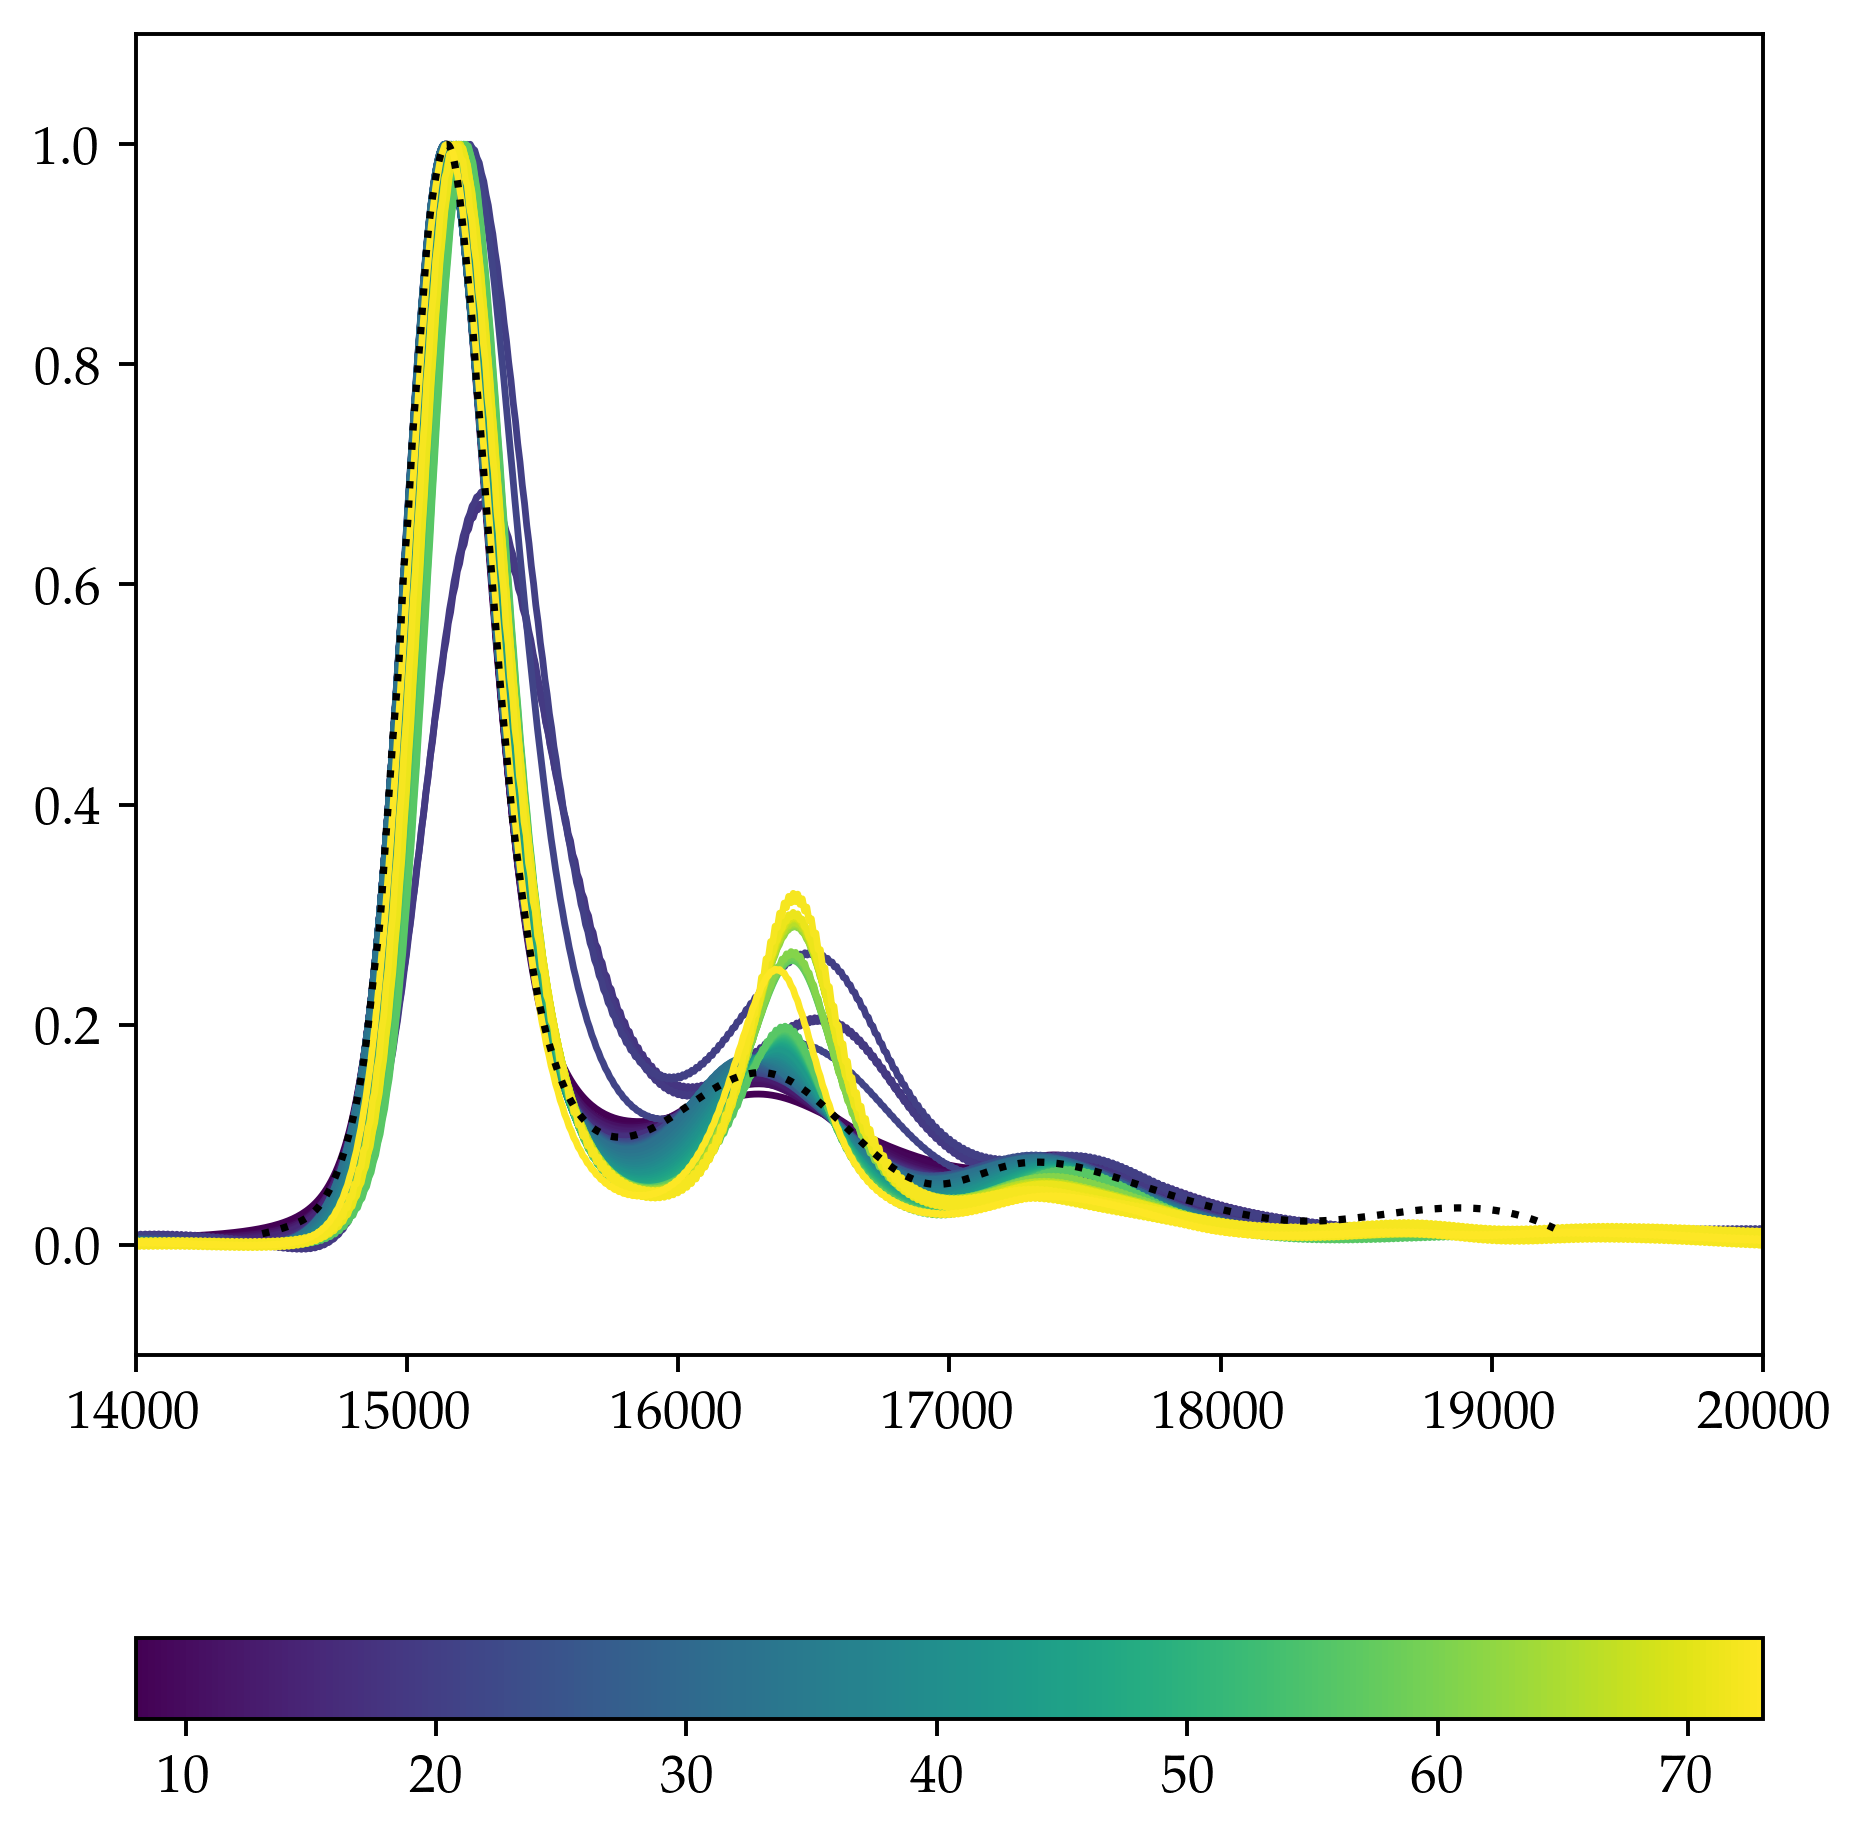

In [12]:
from matplotlib import cm
clm = cm.get_cmap('viridis', len(files))

fig, ax = plt.subplots(figsize=(6,7), dpi= 350)
labels = list()

for i, f in enumerate(sfiles[:]):
    filepath = os.path.join(path, f)
    optpars = spectre.utils.loadjson(filepath)
    datapath = filepath.replace('.json', '.npy')
    
    if os.path.isfile(datapath):
        data = np.load(datapath)
    else:
        syst, ta = spectre.full.init_system(optpars)
        spec = abss.calculate_abs_spectrum(syst, ta, optpars)
        spec.normalize()
        
        with qr.energy_units('1/cm'):
            data = np.vstack([spec.axis.data, spec.data])
            np.save(datapath, data)

    lab = f.split('.')[0].split('_')[2]
    plt.plot(data[0], data[1], label=lab, linewidth=1.4, color=clm(i))
    labels.append(lab)

plt.xlim(14000, 20000)
plt.ylim(-0.1, 1.1)
#plt.legend(frameon=False)

sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(labels[0], labels[-1]))
cbar = plt.colorbar(sm, orientation='horizontal')
#cbar.set_ticklabels(labs)

abss.plot_ref(2, plot_to=ax, color='k', linestyle = 'dotted')

C:\Users\micha\AppData\Local\Temp\ipykernel_46936\1249547784.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  clm = cm.get_cmap('viridis', len(files))
C:\Users\micha\AppData\Local\Temp\ipykernel_46936\1249547784.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot(gs[3])
100%|█████████████████████████████████████████████████████████████████████████████████████| 66/66 [02:52<00:00,  2.61s/it]


Text(0, 0.5, 'residuum')

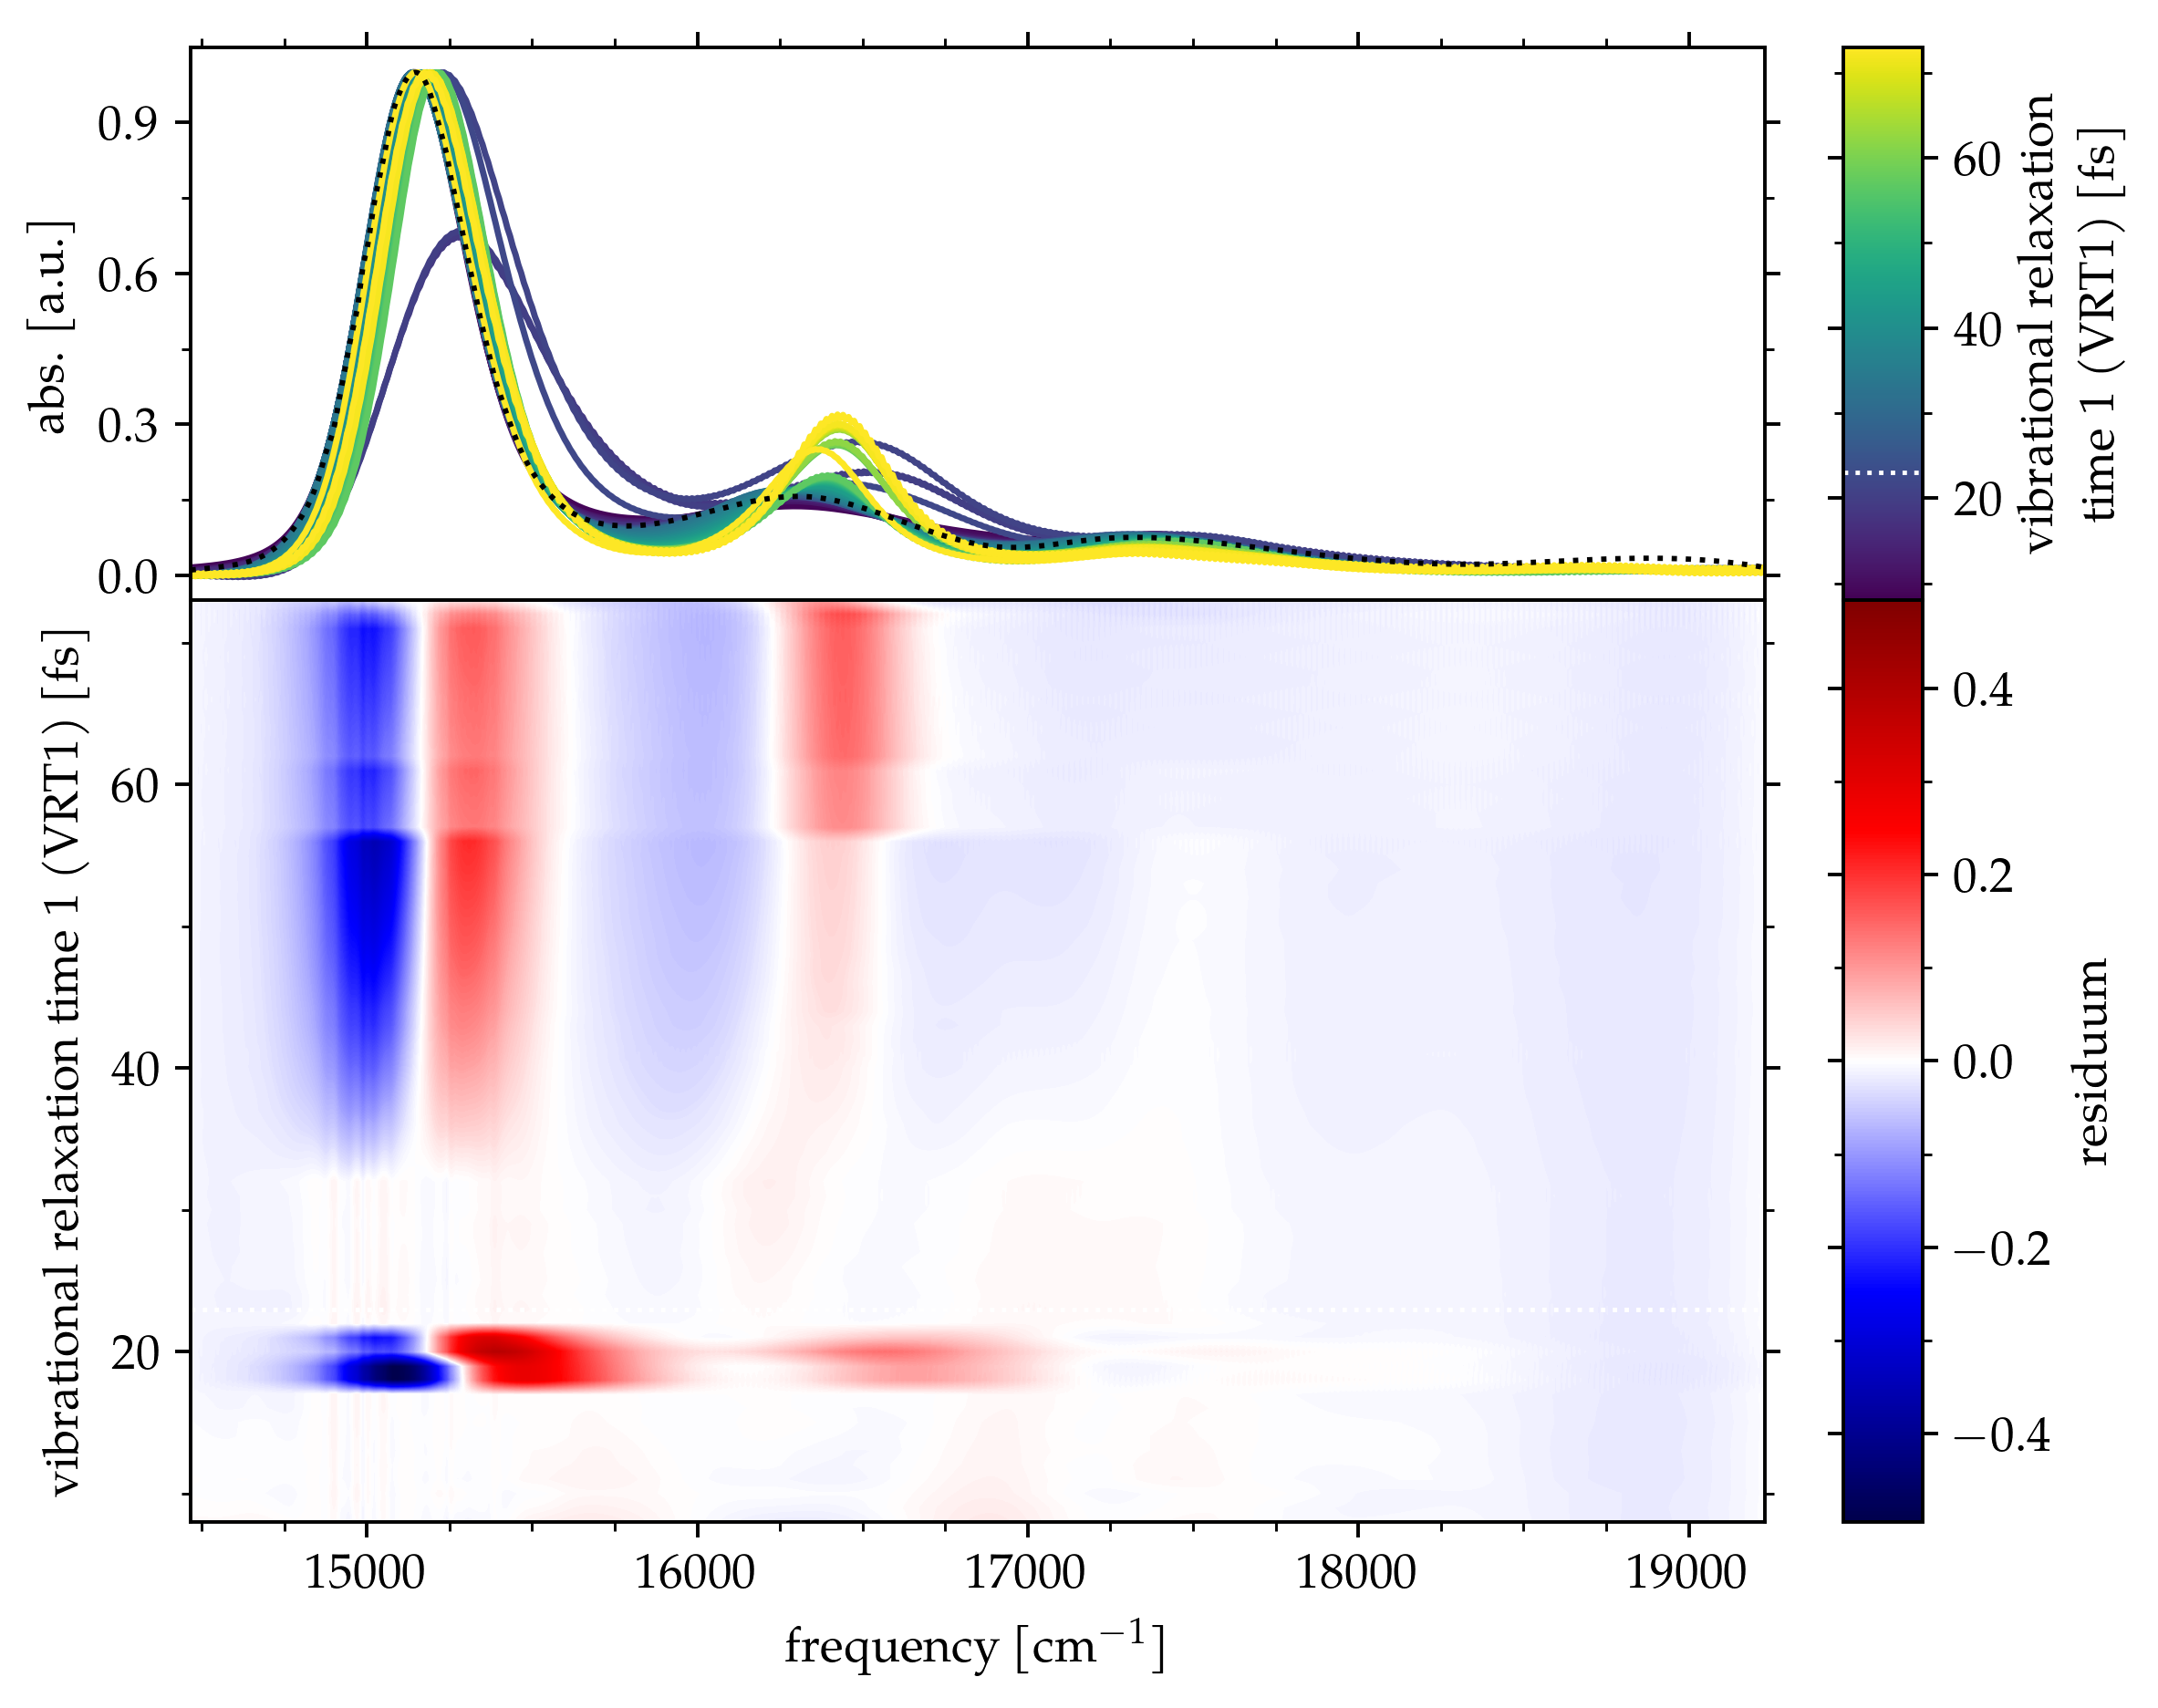

In [13]:
from matplotlib import cm
from scipy.interpolate import UnivariateSpline
from tqdm import tqdm
from matplotlib import gridspec

spline_s=0.0002
spline_k=3

clm = cm.get_cmap('viridis', len(files))

refdata = abss.plot_ref(2, return_data='data', plot=False)
refx, refy = refdata

fig, ax = plt.subplots(num=None, figsize=(7,6), dpi=350, facecolor='w', edgecolor='k')
gs = gridspec.GridSpec(nrows=2, ncols=3, width_ratios=(1, 0.05, 0.05), height_ratios=(0.6, 1), figure=fig) 
#ax3 = plt.subplot(gs[3])
ax0 = plt.subplot(gs[3])
ax1 = plt.subplot(gs[0], sharex = ax0)
ax4 = plt.subplot(gs[5])
ax2 = plt.subplot(gs[2])
plt.subplots_adjust(hspace=0, wspace=0)

####################
#   ax1   #  # ax2 #
####################
#   ax0   #  # ax4 #
####################

all_data_filename = 'all_data.npy'
all_data_path = os.path.join(path, all_data_filename)

if os.path.isfile(all_data_path) and True:
    x, y, zdata = np.load(all_data_path)

    for i, z in enumerate(zdata):
        ax1.plot(x[i], z, linewidth=1.4, color=clm(i))
    
    zax = zdata - refy

else:
    labels = list()
    zax = None
    zdata = None
    i = 0

    for f in tqdm(sfiles[:]):
        i += 1
        filepath = os.path.join(path, f)
        optpars = spectre.utils.loadjson(filepath)
        datapath = filepath.replace('.json', '.npy')
        
        if os.path.isfile(datapath):
            data = np.load(datapath)
        else:
            syst, ta = spectre.full.init_system(optpars)
            spec = abss.calculate_abs_spectrum(syst, ta, optpars)
            spec.normalize()
            
            with qr.energy_units('1/cm'):
                data = np.vstack([spec.axis.data, spec.data])
                np.save(datapath, data)
    
        lab = f.split('.')[0].split('_')[2]
        spline = UnivariateSpline(*data, k=spline_k, s=spline_s)
        ydat = spline(refx) - refy
        
        if zax is None:
            zax = ydat
            zdata = spline(refx)
        else:
            zax = np.vstack([zax, ydat])
            zdata = np.vstack([zdata, spline(refx)])
        
        ax1.plot(data[0], data[1], label=lab, linewidth=1.4, color=clm(i))
        labels.append(float(lab))

    yax = np.array(labels)
    xax = refx
    x, y = np.meshgrid(xax, yax)
    np.save(all_data_path, np.array([x, y, zdata]))

maximum = np.abs(zax).max()

cf = ax0.contourf(x, y, zax, 500, cmap="seismic", vmax=maximum, vmin=-maximum)

#CS = ax0.contour(x, y, zax, 5)
#ax0.clabel(CS, inline=True, fontsize=10)

sm = plt.cm.ScalarMappable(cmap='seismic', norm=plt.Normalize(-maximum, maximum))
cbar = plt.colorbar(sm, cax=ax4, orientation='vertical')

sm2 = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(y[0,0], y[-1,0]))
cbar2 = plt.colorbar(sm2, cax=ax2, orientation='vertical')

ax0.plot([x[0,0], x[0,-1]], [23,23], linewidth=1, linestyle='dotted', c='w')
ax2.plot([0, 1], [23,23], linewidth=1, linestyle='dotted', c='w')

abss.plot_ref(2, plot_to=ax1, linestyle='dotted', c='k', linewidth=1.2)

from matplotlib.ticker import MultipleLocator, AutoMinorLocator, MaxNLocator

for g in [ax0, ax1, ax2, ax4]:
    pars = dict(labelbottom=False, labeltop=False, labelleft=True, labelright=False,
                bottom=True,           top=True,      left=True,      right=True,)
    g.tick_params(which='both', **pars)
    
    #g.xaxis.set_major_locator(MultipleLocator(20))
    #g.xaxis.set_major_formatter('{x:.0f}')
    #g.xaxis.set_minor_locator(MultipleLocator(10))
    g.yaxis.set_major_locator(MaxNLocator(nbins=4))
    g.yaxis.set_minor_locator(AutoMinorLocator(2))
    g.xaxis.set_minor_locator(AutoMinorLocator(4))
    #g.ticklabel_format(style='sci', axis='y', scilimits=(-1,3), useOffset=True)

    #g.get_yaxis().set_offset_position("left")
    #g.get_yaxis().OFFSETTEXTPAD = 7
    #g.get_yaxis().get_offset_text().set_position((-0.097,0))

ax4.yaxis.set_major_locator(MaxNLocator(nbins=5))

ax0.tick_params(which='both', labelbottom=True, labelleft=True)
ax1.tick_params(which='both', bottom=False)
ax2.tick_params(which='both', labelleft=False, labelright=True)
ax4.tick_params(which='both', labelleft=False, labelright=True)

ax0.set_xlim(x[0,0], x[0,-1])
ax1.set_ylim(-0.05, 1.05)

ax0.set_xlabel(r'frequency [cm$^{-1}$]')
ax0.set_ylabel(r'vibrational relaxation time 1 (VRT1) [fs]')
ax1.set_ylabel(r'abs. [a.u.]')
ax2.set_ylabel(r'\parbox{40mm}{\centering vibrational relaxation time 1 (VRT1) [fs]}')
ax4.set_ylabel(r'residuum')

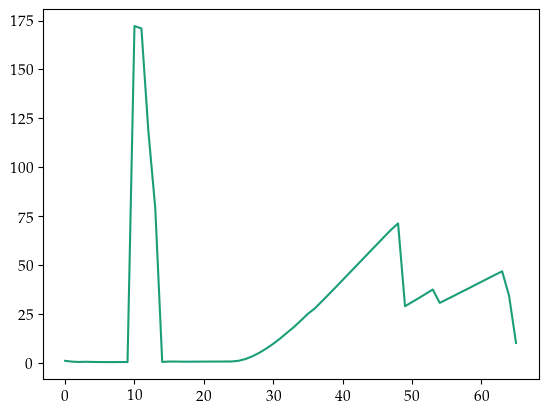

In [14]:
plt.plot((zax**2).sum(axis=1))

In [15]:
def draw_line(plot_to, xaxis, *vals, **pars):
    for val in vals:
        plot_to.plot([xaxis[0]-10, xaxis[-1]+10], [val, val], **pars)

C:\Users\micha\AppData\Local\Temp\ipykernel_46936\2872996659.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  clm = cm.get_cmap('viridis', len(files))


Text(0.5, 0, 'vibrational relaxation time 1 (VRT1) [fs]')

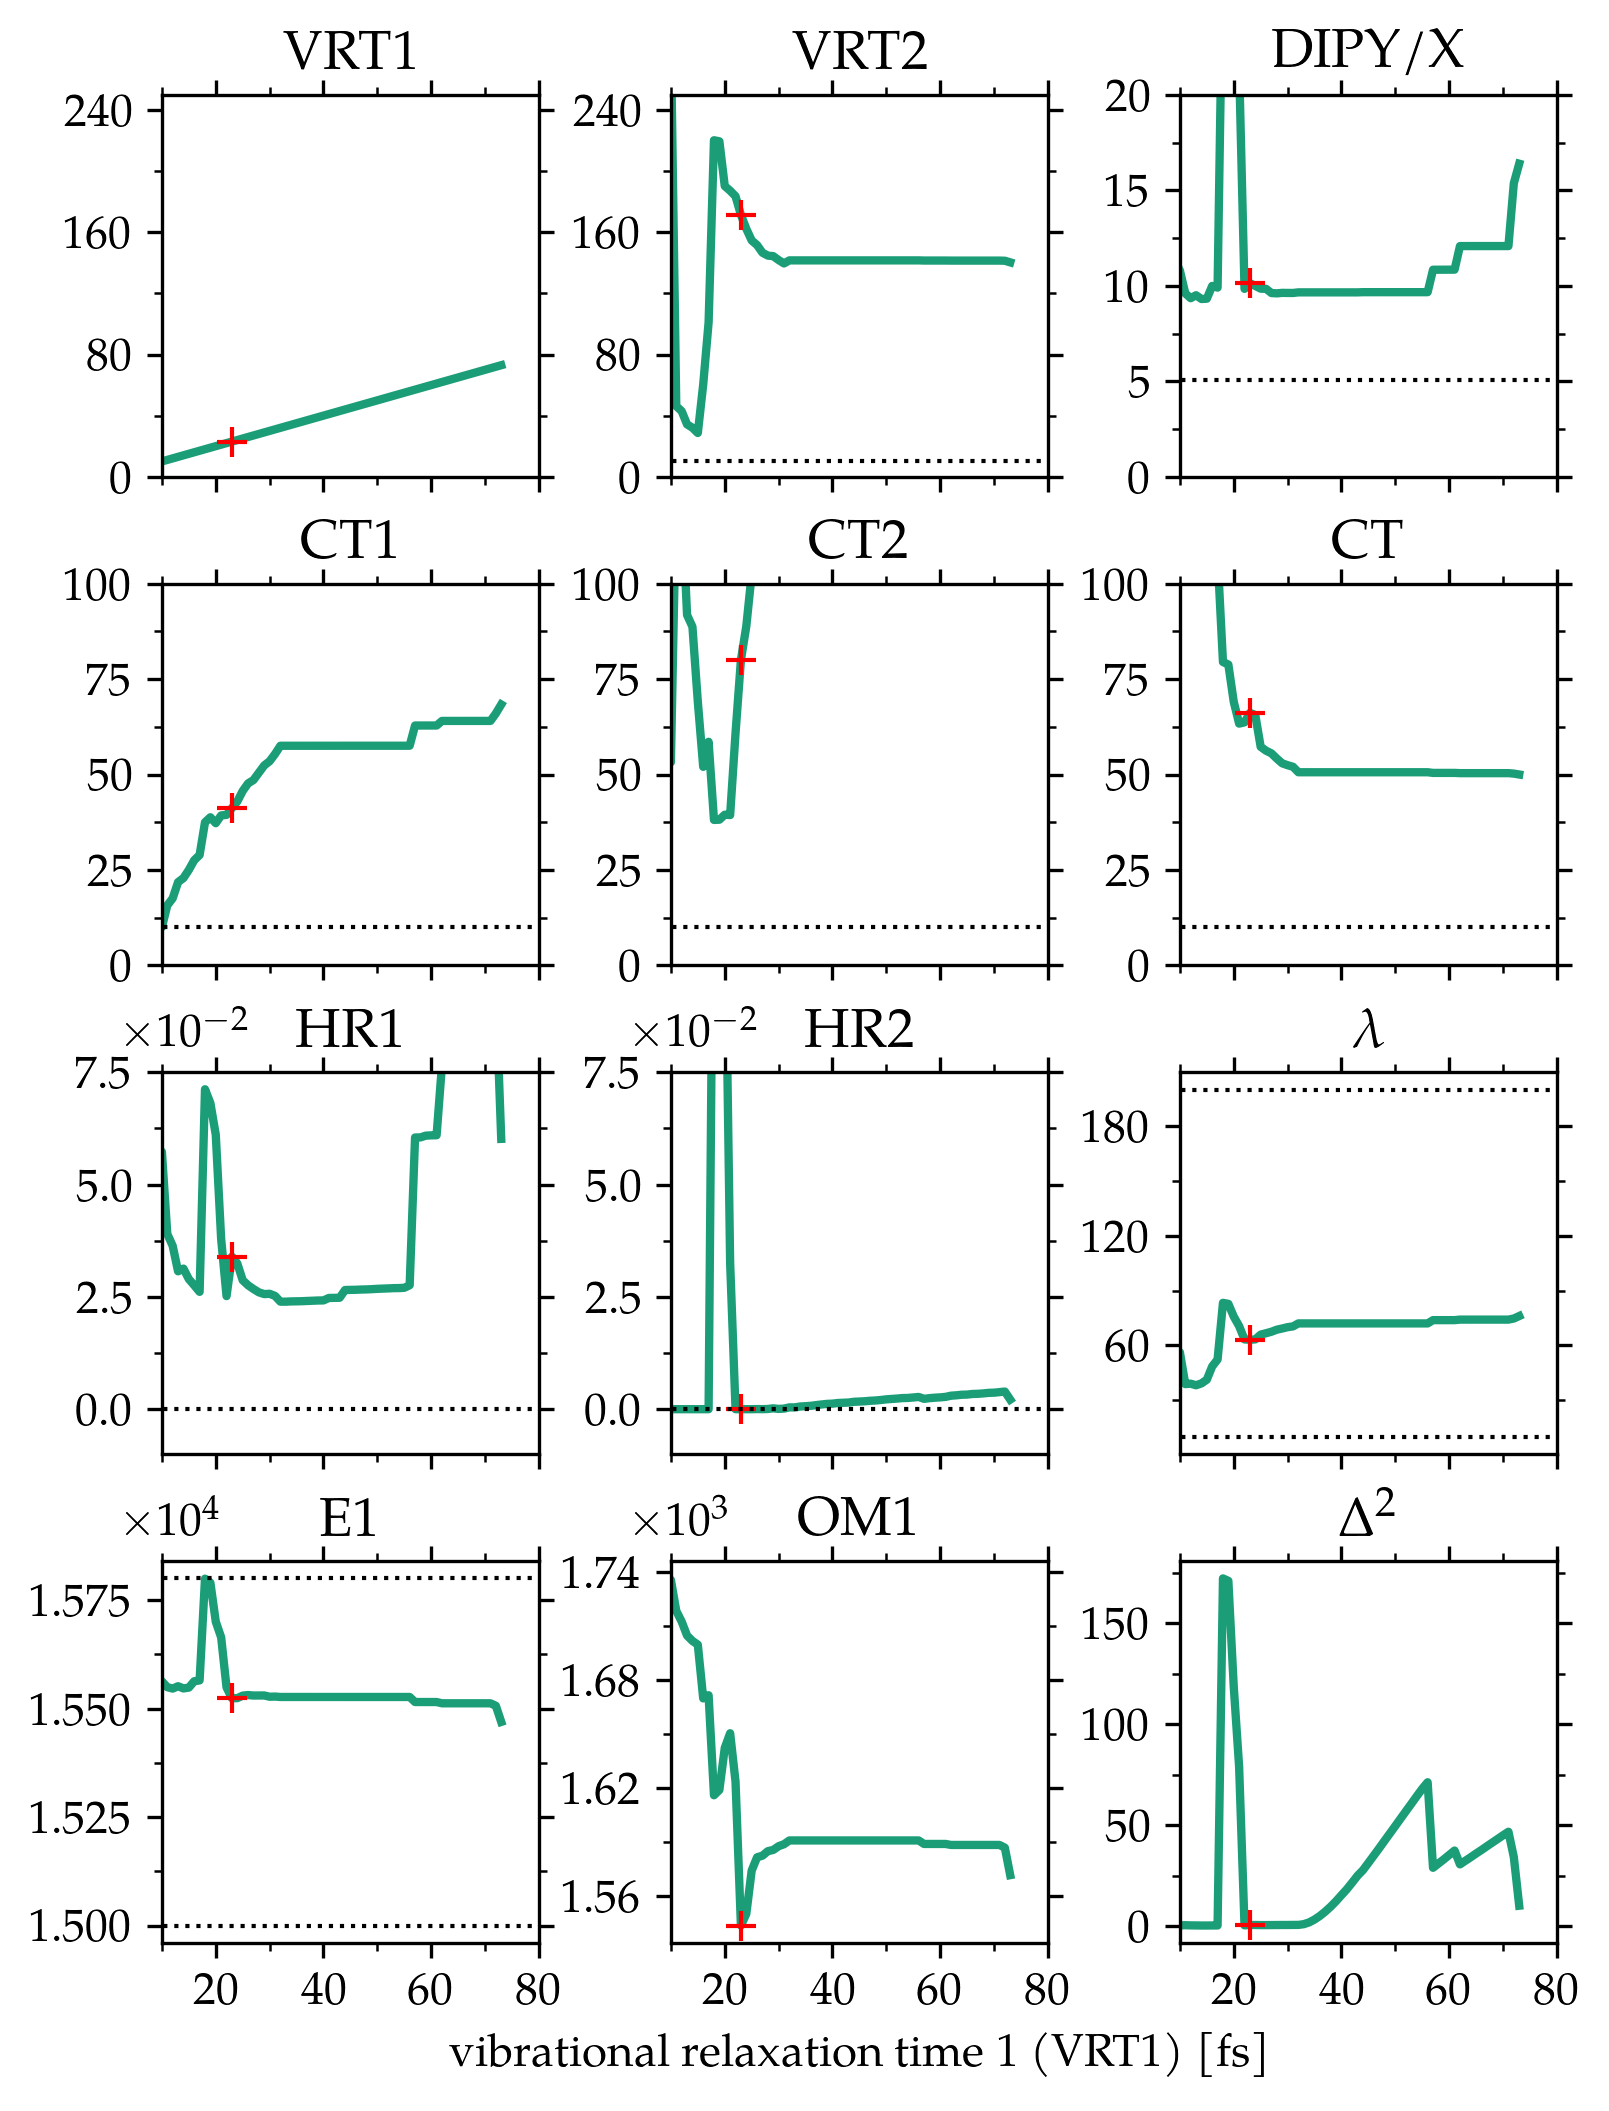

In [16]:
from matplotlib import cm
from spectre.matplotlib_latex import plt_latex, format_ticks

plt_latex()
clm = cm.get_cmap('viridis', len(files))

fig, grid = plt.subplots(4, 3, figsize=(6,8), dpi=300, sharex=True, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=0.28, wspace=0.35)

labels = list()

tt11 = list()
tt12 = list()
dipyx = list()
ct11 = list()
ct12 = list()
ct = list()
lamb = list()
hr11 = list()
hr12 = list()
e1 = list()
de = list()
om1 = list()
alpha = list()

for i, f in enumerate(sfiles[:]):
    filepath = os.path.join(path, f)
    optpars = spectre.utils.loadjson(filepath)
    datapath = filepath.replace('.json', '.npy')
    
    if os.path.isfile(datapath):
        data = np.load(datapath)
    else:
        syst, ta = spectre.full.init_system(optpars)
        spec = abss.calculate_abs_spectrum(syst, ta, optpars)
        spec.normalize()
        
        with qr.energy_units('1/cm'):
            data = np.vstack([spec.axis.data, spec.data])
            np.save(datapath, data)

    lab = f.split('.')[0].split('_')[2]
    labels.append(float(lab))

    tt11.append(optpars['scaled_OB_CF_vib_11']['target_time'])
    tt12.append(optpars['scaled_OB_CF_vib_12']['target_time'])
    dipyx.append(4.5**2 / optpars['dipx'][0]**2)
    ct11.append(optpars['scaled_OB_CF_vib_11']['cortime'])
    ct12.append(optpars['scaled_OB_CF_vib_12']['cortime'])
    ct.append(optpars['spectral_density_el']['cortime'])
    lamb.append(optpars['spectral_density_el']['reorg'])
    hr11.append(optpars['hr1'][0])
    hr12.append(optpars['hr1'][1])
    e1.append(optpars['energies'][1])
    de.append(optpars['energies'][2] - optpars['energies'][1])
    om1.append(optpars['omega'][0])
    alpha.append(optpars['dia_alpha1'])

ii = [i for i,x in enumerate(labels) if x == 23][0]

### Line & marker parameters
pars = dict(linewidth=2, )
mpars = dict(marker='+', c='r', markersize=7)
lpars = dict(linewidth=1, linestyle='dotted', c='k')


## TT11
grid[0,0].plot(labels, tt11, **pars)
grid[0,0].plot(labels[ii], tt11[ii], **mpars)
grid[0,0].set_title('VRT1')

## TT12
grid[0,1].plot(labels, tt12, **pars)
grid[0,1].plot(labels[ii], tt12[ii], **mpars)
grid[0,1].set_title('VRT2')
draw_line(grid[0,1], labels, 10, 300, **lpars)
          
## DIP Y/X
grid[0,2].plot(labels, dipyx, **pars)
grid[0,2].plot(labels[ii], dipyx[ii], **mpars)
grid[0,2].set_title('DIPY/X')
draw_line(grid[0,2], labels, 4.5**2 / 0.2**2, 4.5**2 / 2**2, **lpars)

## CT11
grid[1,0].plot(labels, ct11, **pars)
grid[1,0].plot(labels[ii], ct11[ii], **mpars)
grid[1,0].set_title('CT1')
draw_line(grid[1,0], labels, 10, 200, **lpars)

## CT12
grid[1,1].plot(labels, ct12, **pars)
grid[1,1].plot(labels[ii], ct12[ii], **mpars)
grid[1,1].set_title('CT2')
draw_line(grid[1,1], labels, 10, 200, **lpars)

## CT
grid[1,2].plot(labels, ct, **pars)
grid[1,2].plot(labels[ii], ct[ii], **mpars)
grid[1,2].set_title('CT')
draw_line(grid[1,2], labels, 10, 200, **lpars)

## HR11
grid[2,0].plot(labels, hr11, **pars)
grid[2,0].plot(labels[ii], hr11[ii], **mpars)
grid[2,0].set_title('HR1')
draw_line(grid[2,0], labels, 0.00001, 0.4, **lpars)

## HR12
grid[2,1].plot(labels, hr12, **pars)
grid[2,1].plot(labels[ii], hr12[ii], **mpars)
grid[2,1].set_title('HR2')
draw_line(grid[2,1], labels, 0.00001, 0.4, **lpars)

## lambda
grid[2,2].plot(labels, lamb, **pars)
grid[2,2].plot(labels[ii], lamb[ii], **mpars)
grid[2,2].set_title(r'$\lambda$')
draw_line(grid[2,2], labels, 10, 200, **lpars)

## e1
grid[3,0].plot(labels, e1, **pars)
grid[3,0].plot(labels[ii], e1[ii], **mpars)
grid[3,0].set_title('E1')
draw_line(grid[3,0], labels, 15000, 15800, **lpars)

## omega
grid[3,1].plot(labels, om1, **pars)
grid[3,1].plot(labels[ii], om1[ii], **mpars)
grid[3,1].set_title('OM1')
#draw_line(grid[3,1], labels, 0.00001, 0.4, **lpars)

# ## alpha
# grid[3,2].plot(labels, alpha, **pars)
# grid[3,2].plot(labels[ii], alpha[ii], **mpars)
# grid[3,2].set_title(r'$\alpha$')
# #draw_line(grid[3,2], labels, 0.00001, 0.4, **lpars)

## alpha
delta = (zax**2).sum(axis=1)
grid[3,2].plot(labels, delta, **pars)
grid[3,2].plot(labels[ii], delta[ii], **mpars)
grid[3,2].set_title(r'$\Delta^2$')
#draw_line(grid[3,2], labels, 0.00001, 0.4, **lpars)
    


grid[0,0].set_ylim(0,250)
grid[0,1].sharey(grid[0,0])
# grid[0,1].set_ylim(0,250)

grid[1,0].set_ylim(0,100)
grid[1,1].sharey(grid[1,0])
grid[1,2].sharey(grid[1,0])
# grid[1,1].set_ylim(0,100)
# grid[1,2].set_ylim(0,100)

grid[2,0].set_ylim(-0.01, 0.075)
grid[2,1].sharey(grid[2,0])
# grid[2,1].set_ylim(-0.01, 0.075)

grid[0,0].set_xlim(10, 80)

grid[0,2].set_ylim(0,20)

#plt.xlim(14000, 20000)
#plt.ylim(-0.1, 1.1)
#plt.legend(frameon=False)

#sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(labels[0], labels[-1]))
#cbar = plt.colorbar(sm, orientation='horizontal')
#cbar.set_ticklabels(labs)

### TICKS
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, MaxNLocator

for g in grid[:].flatten():
    pars = dict(labelbottom=False, labeltop=False, labelleft=True, labelright=False,
                bottom=True,           top=True,      left=True,      right=True,)
    #minor_pars = dict(bottom=True,           top=True,      left=True,      right=True)
    g.tick_params(which='both', **pars)
    #g.minor_tick_params(**minor_pars)
    
    g.xaxis.set_major_locator(MultipleLocator(20))
    g.xaxis.set_major_formatter('{x:.0f}')
    g.xaxis.set_minor_locator(MultipleLocator(10))
    g.yaxis.set_major_locator(MaxNLocator(nbins=4))
    g.yaxis.set_minor_locator(AutoMinorLocator(2))
    g.ticklabel_format(style='sci', axis='y', scilimits=(-1,3), useOffset=True)

    g.get_yaxis().set_offset_position("left")
    g.get_yaxis().OFFSETTEXTPAD = 7
    #g.get_yaxis().get_offset_text().set_position((-0.032,0))
    g.get_yaxis().get_offset_text().set_position((-0.097,0))

for g in grid[-1].flatten():
    pars = dict(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
    g.tick_params(which='both', **pars)

# plt.locator_params(axis='x', nbins=4)
# plt.locator_params(axis='y', nbins=4)
#fig.tight_layout()

grid[3,1].set_xlabel('vibrational relaxation time 1 (VRT1) [fs]')